# Used Packages

In [1]:
import os
import glob
import gc

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from scipy.spatial.transform import Rotation as R

from utils.MovingAverager import *
from collections import defaultdict
from torchinfo import summary

from datetime import datetime
from random import randint

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Global Variable

In [2]:
rotation = False
num_of_axis = 3

datapoint_per_second = 20
duration = 2
seq_len = 10

In [4]:
validation_traj = np.load(f'./window_5/all_user_match_data.npy', allow_pickle=True)

In [5]:
# parent_path = '/root/Calibration/R403/model'
# tim = datetime.now().strftime("%b%d%Y")
# path = os.path.join(parent_path, tim+'_Calibrate')
# try:
#     os.makedirs(path, exist_ok=True)
#     print("Directory '%s' created successfully" % path)
# except OSError as error:
#     print("Directory '%s' can not be created")

In [6]:
class KalmanFilter:
    def __init__(self, dt, gyro_noise_std, acc_noise_std):
        self.dt = dt
        self.gyro_noise_std = gyro_noise_std
        self.acc_noise_std = acc_noise_std
        
        self.Q = np.eye(3) * gyro_noise_std**2
        self.R = np.eye(3) * acc_noise_std**2
        
        self.P = np.eye(3)
        self.x = np.zeros(3)
    
    def predict(self, gyro_measurements):
        F = np.eye(3) + self.dt * self.skew_symmetric(gyro_measurements)
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + self.Q
    
    def update(self, acc_measurements, Rk):
        z = acc_measurements
        H = np.eye(3)
        y = z - H @ self.x
        S = H @ self.P @ H.T + Rk
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(3) - K @ H) @ self.P
    
    def skew_symmetric(self, v):
        return np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])

class AttitudeEstimator:
    def __init__(self, dt, gyro_noise_std, acc_noise_std, method='STF'):
        self.kf = KalmanFilter(dt, gyro_noise_std, acc_noise_std)
        self.method = method
    
    def estimate_attitude(self, gyro_measurements, acc_measurements):
        self.kf.predict(gyro_measurements)
        Rk = self.adaptive_measurement_noise_covariance(acc_measurements)
        self.kf.update(acc_measurements, Rk)
        return self.kf.x
    
    def adaptive_measurement_noise_covariance(self, acc_measurements):
        if self.method == 'STF':
            return self.adaptive_measurement_noise_covariance_stf(acc_measurements)
        elif self.method == 'MTF':
            return self.adaptive_measurement_noise_covariance_mtf(acc_measurements)
        else:
            raise ValueError("Method must be 'STF' or 'MTF'")
    
    def adaptive_measurement_noise_covariance_stf(self, acc_measurements):
        innovation = acc_measurements - self.kf.x
        St = np.sum(innovation**2) / 3 - np.trace(self.kf.R) / 3
        St = max(0, St)
        return np.eye(3) * St
    
    def adaptive_measurement_noise_covariance_mtf(self, acc_measurements):
        innovation = acc_measurements - self.kf.x
        St = np.zeros(3)
        for i in range(3):
            St[i] = max(0, innovation[i]**2 - self.kf.R[i, i])
        return np.diag(St)
    
    def get_roll_pitch(self):
        roll = np.arctan2(self.kf.x[1], self.kf.x[2])
        pitch = np.arctan2(-self.kf.x[0], np.sqrt(self.kf.x[1]**2 + self.kf.x[2]**2))
        return roll, pitch

class RotationMatrixCalculator:
    @staticmethod
    def from_roll_pitch(roll, pitch):
        R_x = np.array([
            [1, 0, 0],
            [0, np.cos(roll), -np.sin(roll)],
            [0, np.sin(roll), np.cos(roll)]
        ])
        
        R_y = np.array([
            [np.cos(pitch), 0, np.sin(pitch)],
            [0, 1, 0],
            [-np.sin(pitch), 0, np.cos(pitch)]
        ])
        
        R = R_x @ R_y
        return R

estimator = AttitudeEstimator(0.05, 0.01, 0.1, 'MTF')    

def process_sequence(gyro_data, acc_data, acc_lin_data, mag_data):
    rotation_matrices = []
    rotated_acc_data = []
    rotated_acc_lin_data = []
    rotated_mag_data = []
    rotated_gyro_data = []
    
    for gyro_measurements, acc_measurements, acc_lin_measurements, mag_measurements in zip(gyro_data, acc_data, acc_lin_data, mag_data):
        estimator.estimate_attitude(np.array(gyro_measurements), np.array(acc_measurements))
        roll, pitch = estimator.get_roll_pitch()
        R = RotationMatrixCalculator.from_roll_pitch(roll, pitch)
        
        rotated_acc = R @ np.array(acc_measurements)
        rotated_gyro = R @ np.array(gyro_measurements)
        rotated_acc_lin = R @ np.array(acc_lin_measurements)
        rotated_mag = R @ np.array(mag_measurements)
        
        rotation_matrices.append(R)
        rotated_acc_data.append(rotated_acc)
        rotated_acc_lin_data.append(rotated_acc_lin)
        rotated_gyro_data.append(rotated_gyro)
        rotated_mag_data.append(rotated_mag)
    
    return np.concatenate((np.array(rotated_acc_data), np.array(rotated_acc_lin_data), np.array(rotated_gyro_data)), axis=-1), np.array(rotated_mag_data),

In [7]:
def get_data(validation_traj, num_of_axis, rotation):    
    posture_data = defaultdict(list)

    valid_data = validation_traj.item()
    for user_name in valid_data.keys():
        for path_name in valid_data[user_name].keys():
            for posture_name in valid_data[user_name][path_name].keys():
                data = valid_data[user_name][path_name][posture_name]

                if posture_name == 'ref_mag':
                    if num_of_axis == 2:
                        posture_data[posture_name].append(data[:, [0, 1, 6, 7, 5]])
                    else:
                        posture_data[posture_name].append(data[:, [0, 1, 2, 3, 4, 6, 7, 5]])
                    continue

                pos = (data[:, [0, 1]] + np.array((1, 1))) * 0.6
                imu = data[:, [3, 4, 5, 6, 7, 8, 9, 10, 11]]
#                 imu[:, 3:6] *= 10
#                 imu[:, 6:9] = imu[:, 6:9] * 18 / np.pi
                mag = data[:, [12, 13, 14]]

                if rotation:
                    imu, mag = process_sequence(imu[:, 6:9], imu[:, 0:3], imu[:, 3:6], mag)
                if num_of_axis == 2: 
                    mag = np.column_stack((np.sqrt(np.sum(mag[:, :2]**2, axis=1)), mag[:, 2]))
#                 imu = imu[:, [0, 3, 6, 1, 4, 7, 2, 5, 8]]
                pos_mag = np.concatenate((pos, imu, mag, data[:, [15]]), axis=-1)            
                posture_data[posture_name].append(pos_mag)
    
    return posture_data

In [8]:
def split_traj(trajs, length=20):
    sp_traj = []
    for traj in trajs:
        for i in range(len(traj) - length + 1):
            sp_traj.append(traj[i:i+length])
    return np.array(sp_traj)

In [9]:
datapoint_per_second = 20
duration = 2
seq_len = 20

# Data Loader

In [10]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        assert (source_data.shape[0] == source_label.shape[0] == target_data.shape[0] == target_label.shape[0]), f'{source_data.shape}, {source_label.shape}, {target_data.shape}, {target_label.shape}'
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label
        self.normalize()

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]
    
    def normalize(self):
        s_mean = self.source_data.mean(dim=0, keepdim=True)
        s_std = self.source_data.std(dim=0, keepdim=True)
        
        self.source_data  = (self.source_data - s_mean / s_std)
        t_mean = self.target_data.mean(dim=0, keepdim=True)
        t_std = self.target_data.std(dim=0, keepdim=True)
        
        self.target_data  = (self.target_data - t_mean / t_std)

In [11]:
def for_dataloaders(traj, gt='target'):
    t_data = 0
    t_label = 0
    t_target_data = 0
    v_data = 0
    v_label = 0
    v_target_data = 0
    label = 1
    label_dict = {}
    flag = False
    for key, value in traj.items():
        split = len(value) * 9 // 10
        tmp1, tmp2 = value[:split], value[split:]
        if key != gt: 
            t_data = np.concatenate((t_data, tmp1)) if flag else tmp1
            t_label = np.concatenate((t_label, np.full((tmp1.shape[0], ), label))) if flag else np.full((tmp1.shape[0], ), label)
            v_data = np.concatenate((v_data, tmp2)) if flag else tmp2
            v_label = np.concatenate((v_label, np.full((tmp2.shape[0], ), label))) if flag else np.full((tmp2.shape[0], ), label)
            flag = True
            label_dict[label] = key
            label += 1
        else:
            l = len(traj.values()) - 1
            t_target_data = np.tile(tmp1, (l, 1, 1))
            v_target_data = np.tile(tmp2, (l, 1, 1))
            label_dict[0] = key
    
    train_dataset = PairDataset(
                        source_data = torch.tensor(t_data, dtype=torch.float),
                        source_label = t_label,
                        target_data = torch.tensor(t_target_data, dtype=torch.float),
                        target_label = np.zeros((len(t_target_data), ))
                    )
    
    valid_dataset = PairDataset(
                        source_data = torch.tensor(v_data, dtype=torch.float),
                        source_label = v_label,
                        target_data = torch.tensor(v_target_data, dtype=torch.float),
                        target_label = np.zeros((len(v_target_data), ))
                    )

    print(label_dict)
    return label_dict, train_dataset, valid_dataset

# Model Declaration

In [12]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]

        # calculate the loss as the mean squared error of the derivative
        loss = mae_loss(d_source, d_target)

        return loss

In [13]:
def generator_loss(z_imu, target_imu):
    acc_loss = mse_loss(z_imu[:, :, :3], target_imu[:, :, :3])
    lin_loss = mse_loss(z_imu[:, :, 3:6], target_imu[:, :, 3:6])
    gyr_loss = mse_loss(z_imu[:, :, 6:], target_imu[:, :, 6:])
    total_loss = acc_loss + lin_loss + gyr_loss
    
    return total_loss, (acc_loss, lin_loss, gyr_loss)

In [14]:
num_of_classes = 3
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
mae_loss = torch.nn.L1Loss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

In [15]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    return mask.to(device)

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        self.mag_axis = num_of_axis
        
        self.acc_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            PositionalEncoding(16, 0.1)
        )
        
        self.lin_acc_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            PositionalEncoding(16, 0.1)
        )
        
        self.gyro_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            PositionalEncoding(16, 0.1)
        )
        self.pos_encoder = PositionalEncoding(16, 0.1)
        
        self.acc_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
        self.lin_acc_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
        self.gyro_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
        
#         self.fusing = nn.Sequential(
#             nn.Linear(48, 16),
#             nn.LeakyReLU(),
#         )
        
        self.acc_decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
        self.lin_acc_decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
        self.gyro_decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=16, nhead=4, dropout=0.1, batch_first=True), num_layers=1)
        
        self.acc_nn = nn.Linear(16, 3)
        self.lin_acc_nn = nn.Linear(16, 3)
        self.gyro_nn = nn.Linear(16, 3)
        
    def forward(self, source_imu, target_imu=None):
        bs, seq_len, _ = source_imu.size()

        ### step 1
        h_acc = self.acc_layer(source_imu[:, :, :3])
        h_lin = self.lin_acc_layer(source_imu[:, :, 3:6])
        h_gyr = self.gyro_layer(source_imu[:, :, 6:])

        ### step 2
        m_acc = self.acc_encoder(h_acc)
        m_lin = self.lin_acc_encoder(h_lin)
        m_gyr = self.gyro_encoder(h_gyr)
        
#         m_fus = self.fusing(torch.cat((m_acc, m_lin, m_gyr), dim=2))

        if target_imu is not None:
            # If target_imu is provided, use it directly
            t_acc = self.acc_layer(torch.cat((torch.zeros(bs, 1, 3).to(source_imu.device), target_imu[:, :, :3]), dim=1))
            t_lin = self.lin_acc_layer(torch.cat((torch.zeros(bs, 1, 3).to(source_imu.device), target_imu[:, :, 3:6]), dim=1))
            t_gyr = self.gyro_layer(torch.cat((torch.zeros(bs, 1, 3).to(source_imu.device), target_imu[:, :, 6:]), dim=1))

            p_acc = self.acc_decoder(t_acc, m_acc, tgt_mask=get_tgt_mask(seq_len+1))
            p_lin = self.lin_acc_decoder(t_lin, m_lin, tgt_mask=get_tgt_mask(seq_len+1))
            p_gyr = self.gyro_decoder(t_gyr, m_gyr, tgt_mask=get_tgt_mask(seq_len+1))

            p_acc = self.acc_nn(p_acc)
            p_lin = self.lin_acc_nn(p_lin)
            p_gyr = self.gyro_nn(p_gyr)

            p_imu = torch.cat((p_acc[:, 1:, :], p_lin[:, 1:, :], p_gyr[:, 1:, :]), dim=2)
        else:
            # If target_imu is not provided, iteratively generate it
            # Initialize the first target with zeros
            tgt_acc = torch.zeros(bs, 1, 3).to(source_imu.device)
            tgt_lin = torch.zeros(bs, 1, 3).to(source_imu.device)
            tgt_gyr = torch.zeros(bs, 1, 3).to(source_imu.device)

            p_acc = torch.zeros(bs, seq_len, 3).to(source_imu.device)
            p_lin = torch.zeros(bs, seq_len, 3).to(source_imu.device)
            p_gyr = torch.zeros(bs, seq_len, 3).to(source_imu.device)

            for i in range(seq_len):
                # Generate the next step prediction
                t_acc = self.acc_layer(tgt_acc)
                t_lin = self.lin_acc_layer(tgt_lin)
                t_gyr = self.gyro_layer(tgt_gyr)

                p_acc_step = self.acc_decoder(t_acc, m_acc, tgt_mask=get_tgt_mask(i+1))
                p_lin_step = self.lin_acc_decoder(t_lin, m_lin, tgt_mask=get_tgt_mask(i+1))
                p_gyr_step = self.gyro_decoder(t_gyr, m_gyr, tgt_mask=get_tgt_mask(i+1))

                p_acc_step = self.acc_nn(p_acc_step)
                p_lin_step = self.lin_acc_nn(p_lin_step)
                p_gyr_step = self.gyro_nn(p_gyr_step)

                # Update the predictions for the current step
                p_acc[:, i, :] = p_acc_step[:, -1, :]
                p_lin[:, i, :] = p_lin_step[:, -1, :]
                p_gyr[:, i, :] = p_gyr_step[:, -1, :]

                # Update the target for the next iteration
                tgt_acc = torch.cat((tgt_acc, p_acc[:, i:i+1, :]), dim=1)
                tgt_lin = torch.cat((tgt_lin, p_lin[:, i:i+1, :]), dim=1)
                tgt_gyr = torch.cat((tgt_gyr, p_gyr[:, i:i+1, :]), dim=1)

            p_imu = torch.cat((p_acc, p_lin, p_gyr), dim=2)

        return p_imu

In [17]:
def plot_result(result):
    idx = ['acc', 'lin_acc', 'gyro']
    pred_imu = result[0].reshape(-1, 9)
    targ_imu = result[1].reshape(-1, 9)
    x = np.arange(len(pred_imu))
    
    fig = plt.figure(figsize=(15, 10))
    
    for i in range(3):
        start = i * 3
        loss = torch.sqrt(mse_loss(torch.tensor(pred_imu[:, start:start+3]), torch.tensor(targ_imu[:, start:start+3]))).item()
        
        ax = plt.subplot(3, 1, i+1)
        for pm, tm, caxis, color in zip(pred_imu[:, start:start+3].T, targ_imu[:, start:start+3].T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
            plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
            plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
        ax.title.set_text(f'{idx[i]} Loss: {loss:.2f}')

    plt.legend()
    plt.show()

In [18]:
def train(dataloader, draw=False, epoch_ratio=1):
    model.train()

    g_losses = []
    acc_losses = []
    lin_losses = []
    gyr_losses = []
    pred_seqs = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer_acc.zero_grad()
        optimizer_lin.zero_grad()
        optimizer_gyr.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, 2:11] + torch.randn_like(source_data[:, :, 2:11]) * 0.25
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, 2:11]

        # generate mag
        p_imu = model(source_imu, target_imu)
        
        # generator loss
        gen_loss, (acc_loss, lin_loss, gyr_loss) = generator_loss(p_imu, target_imu)
        
        # backward
        acc_loss.backward(retain_graph=True)
        lin_loss.backward(retain_graph=True)
        gyr_loss.backward()
        optimizer_acc.step()
        optimizer_lin.step()
        optimizer_gyr.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        acc_losses.append(acc_loss.item())
        lin_losses.append(lin_loss.item())
        gyr_losses.append(gyr_loss.item())
    
    if draw:
        rs = [p_imu[0].detach().cpu().numpy(), target_imu[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(acc_losses), np.mean(lin_losses), np.mean(gyr_losses)

In [19]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    acc_losses = []
    lin_losses = []
    gyr_losses = []
    pred_seqs = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, 2:11]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, 2:11]

            # generate mag
            p_imu = model(source_imu)

            # generator loss
            gen_loss, (acc_loss, lin_loss, gyr_loss) = generator_loss(p_imu, target_imu)
            
            # record loss
            g_losses.append(gen_loss.item())
            acc_losses.append(acc_loss.item())
            lin_losses.append(lin_loss.item())
            gyr_losses.append(gyr_loss.item())
    
    if draw:
        rs = [p_imu[0].detach().cpu().numpy(), target_imu[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(acc_losses), np.mean(lin_losses), np.mean(gyr_losses)

In [20]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_pos = source_data[:, :, :2]
            source_imu = source_data[:, :, 2:11]

            target_data = target_data.to(device)
            target_pos = target_data[:, :, :2]
            target_imu = target_data[:, :, 2:11]

            # generate mag
            p_imu = model(source_imu)
            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            p_imu = p_imu.detach().cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            target_imu = target_imu.detach().cpu().numpy()
            
            results.extend(zip(p_imu, target_imu, source_label))
            
            acc_diff = np.power(p_imu[:, :, :3] - target_imu[:, :, :3], 2).mean(axis=1)
            lin_diff = np.power(p_imu[:, :, 3:6] - target_imu[:, :, 3:6], 2).mean(axis=1)
            gyr_diff = np.power(p_imu[:, :, 6:] - p_imu[:, :, 6:], 2).mean(axis=1)
            
            class_results.extend(zip(acc_diff, lin_diff, gyr_diff))
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [29]:
def show_result(model, dataloader):
    idx = ['acc', 'lin_acc', 'gyro']
    results, cres, clabel = output_eval(model, dataloader)
    print(results.shape, cres.shape, clabel.shape)
    for i in range(3):
        print(f'{idx[i]+" loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
        for class_label, class_name in classes.items():
            if sum(clabel == class_label) <= 0:
                continue
            dx, dy, dz = cres[clabel == class_label][:, :, i].mean(axis=0)
            print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
        dx, dy, dz = cres[:, i].mean(axis=0)
        print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

    for rs in results[::500]:
        plot_result(rs)

# Experiment 1
rotation = False
num_of_axis = 2Different final ground truth (最終姿態)

In [22]:
num_of_axis, rotation, gt = 3, False, 'target'

posture_data = get_data(validation_traj, num_of_axis, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'])
# prep_valid_traj['horizontal']   = split_traj(posture_data['horizontal'])
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'])
prep_valid_traj['swing']        = split_traj(posture_data['swing'])
prep_valid_traj['target']       = split_traj(posture_data['target'])

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
acc_para = list(model.acc_layer.parameters()) + list(model.acc_encoder.parameters()) + list(model.acc_decoder.parameters()) + list(model.acc_nn.parameters())
lin_para = list(model.lin_acc_layer.parameters()) + list(model.lin_acc_encoder.parameters()) + list(model.lin_acc_decoder.parameters()) + list(model.lin_acc_nn.parameters())
gyr_para = list(model.gyro_layer.parameters()) + list(model.gyro_encoder.parameters()) + list(model.gyro_decoder.parameters()) + list(model.gyro_nn.parameters())

optimizer_acc = torch.optim.Adam(acc_para, lr=0.0001)
optimizer_lin = torch.optim.Adam(lin_para, lr=0.0001)
optimizer_gyr = torch.optim.Adam(gyr_para, lr=0.0001)

{1: 'front_pocket', 2: 'pocket', 3: 'swing', 0: 'target'}


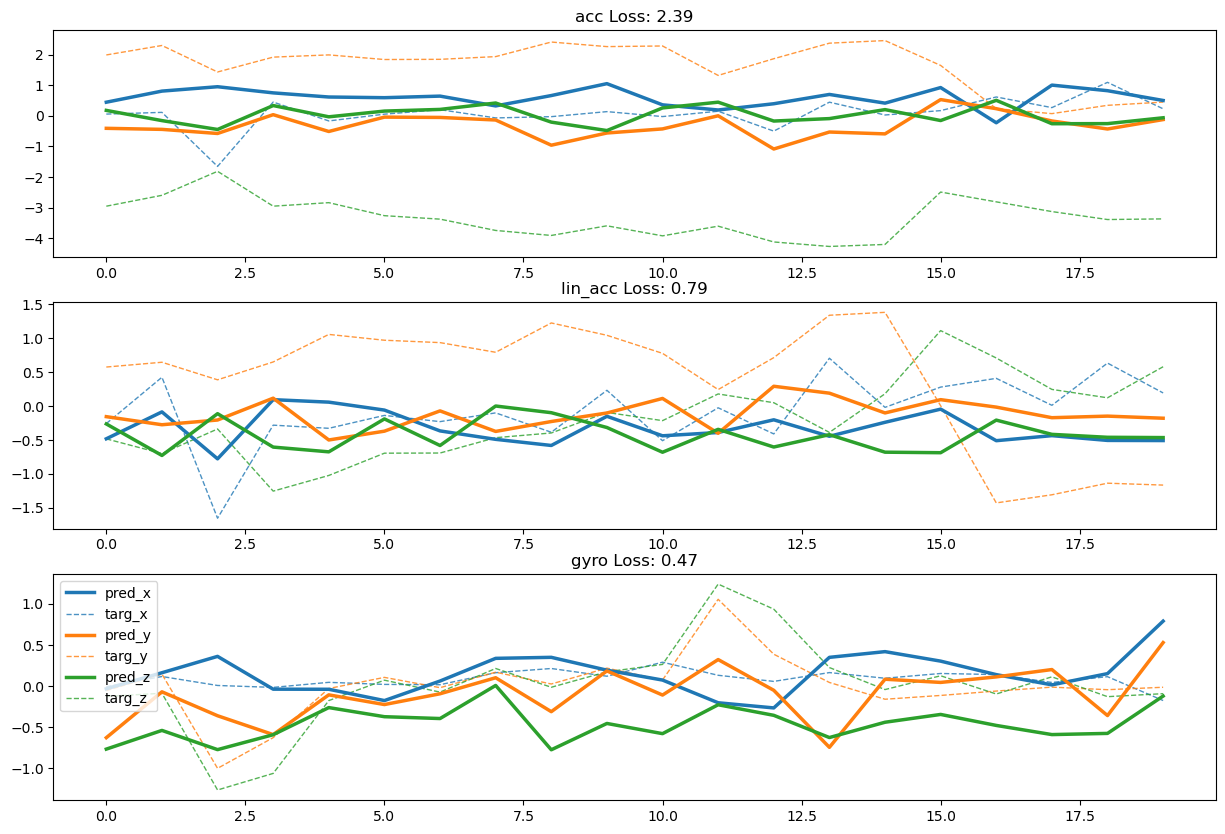

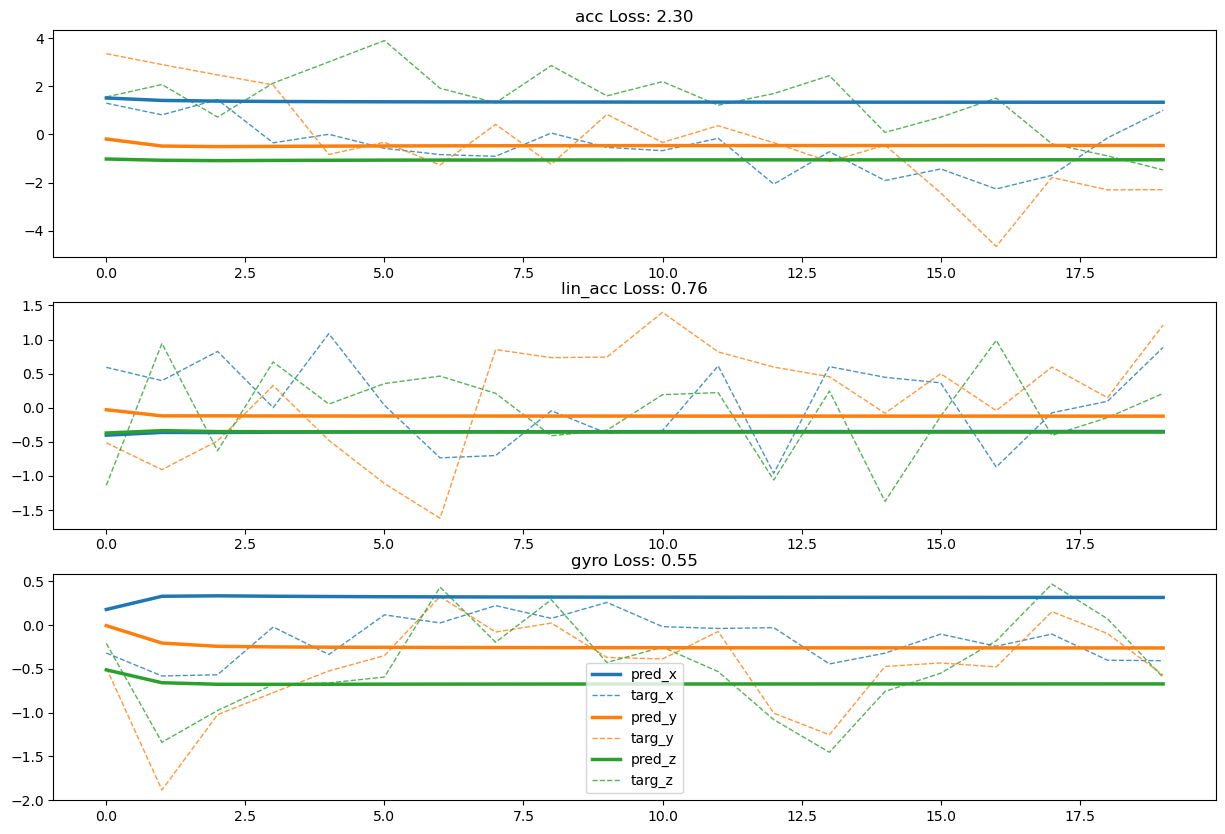

00000: train loss:   5.191, acc loss:  4.327, lin loss:  0.572, gyr loss:  0.292
       valid loss:   5.981, acc loss:  4.791, lin loss:  0.756, gyr loss:  0.434
00100: train loss:   0.779, acc loss:  0.644, lin loss:  0.093, gyr loss:  0.042
       valid loss:   8.364, acc loss:  7.061, lin loss:  0.951, gyr loss:  0.352
00200: train loss:   0.392, acc loss:  0.313, lin loss:  0.053, gyr loss:  0.026
       valid loss:   6.481, acc loss:  5.240, lin loss:  0.899, gyr loss:  0.343
00300: train loss:   0.255, acc loss:  0.198, lin loss:  0.038, gyr loss:  0.019
       valid loss:   5.845, acc loss:  4.640, lin loss:  0.858, gyr loss:  0.347
00400: train loss:   0.200, acc loss:  0.151, lin loss:  0.032, gyr loss:  0.017
       valid loss:   6.321, acc loss:  5.160, lin loss:  0.807, gyr loss:  0.354
00500: train loss:   0.148, acc loss:  0.106, lin loss:  0.027, gyr loss:  0.015
       valid loss:   6.925, acc loss:  5.714, lin loss:  0.815, gyr loss:  0.396
00600: train loss:   0.126, 

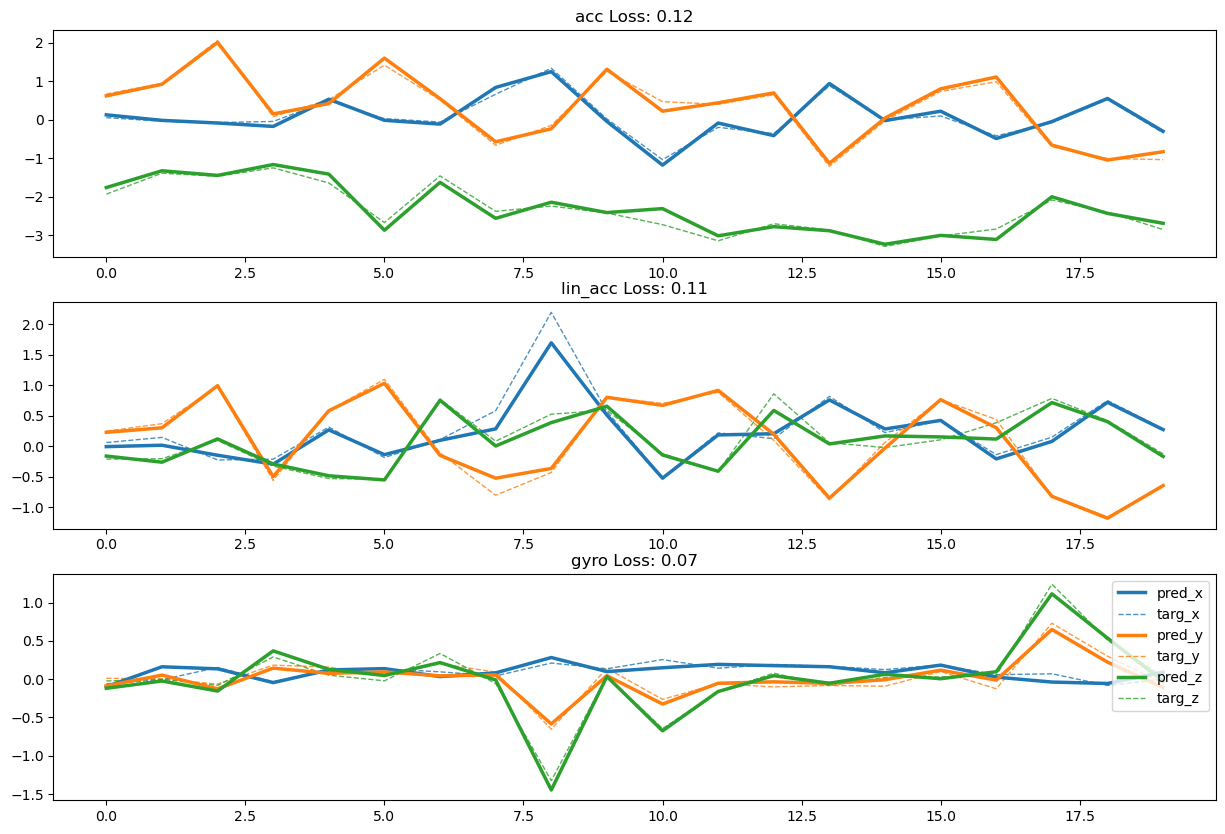

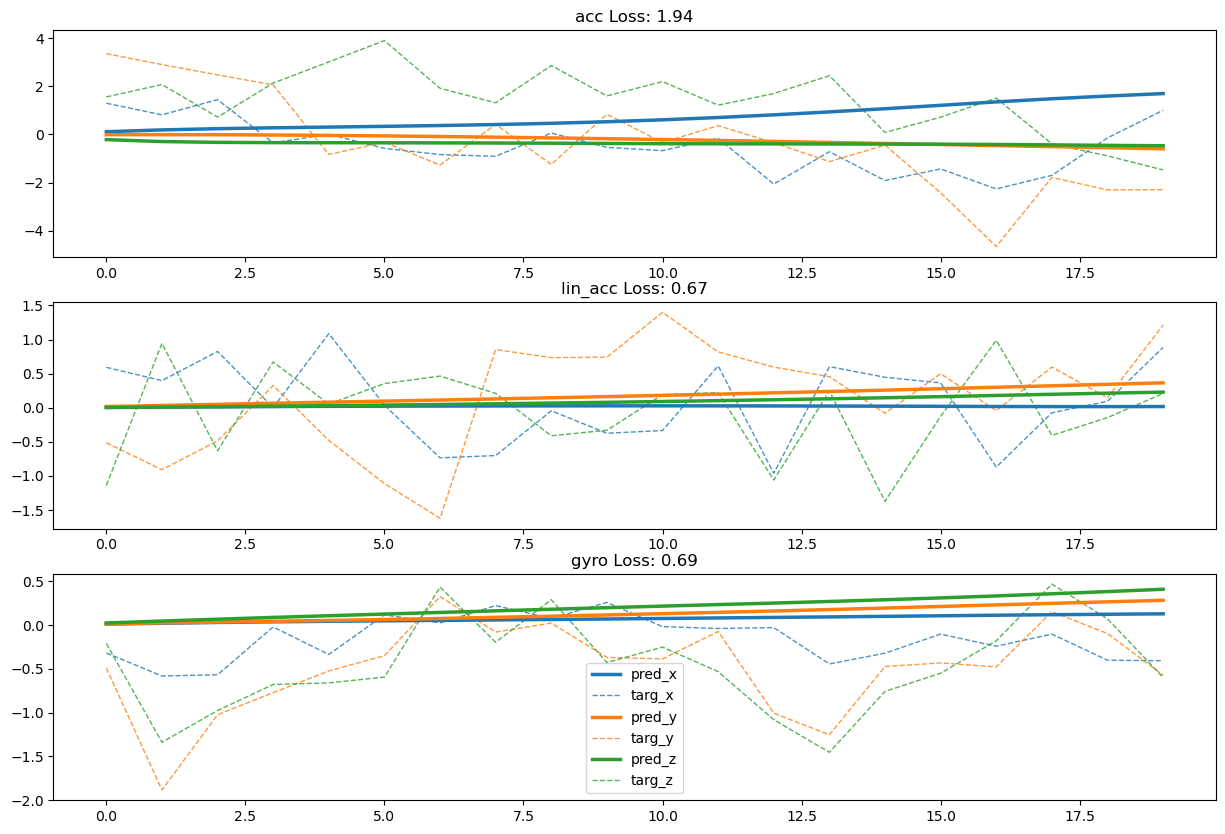

02000: train loss:   0.037, acc loss:  0.024, lin loss:  0.008, gyr loss:  0.006
       valid loss:   4.807, acc loss:  3.767, lin loss:  0.669, gyr loss:  0.371
02100: train loss:   0.038, acc loss:  0.025, lin loss:  0.007, gyr loss:  0.006
       valid loss:   4.865, acc loss:  3.837, lin loss:  0.663, gyr loss:  0.365
02200: train loss:   0.034, acc loss:  0.022, lin loss:  0.006, gyr loss:  0.006
       valid loss:   5.044, acc loss:  3.993, lin loss:  0.668, gyr loss:  0.383
02300: train loss:   0.033, acc loss:  0.021, lin loss:  0.006, gyr loss:  0.005
       valid loss:   5.079, acc loss:  4.065, lin loss:  0.662, gyr loss:  0.352
02400: train loss:   0.031, acc loss:  0.020, lin loss:  0.006, gyr loss:  0.005
       valid loss:   4.796, acc loss:  3.766, lin loss:  0.665, gyr loss:  0.365
02500: train loss:   0.031, acc loss:  0.020, lin loss:  0.006, gyr loss:  0.005
       valid loss:   4.979, acc loss:  3.954, lin loss:  0.680, gyr loss:  0.345
02600: train loss:   0.030, 

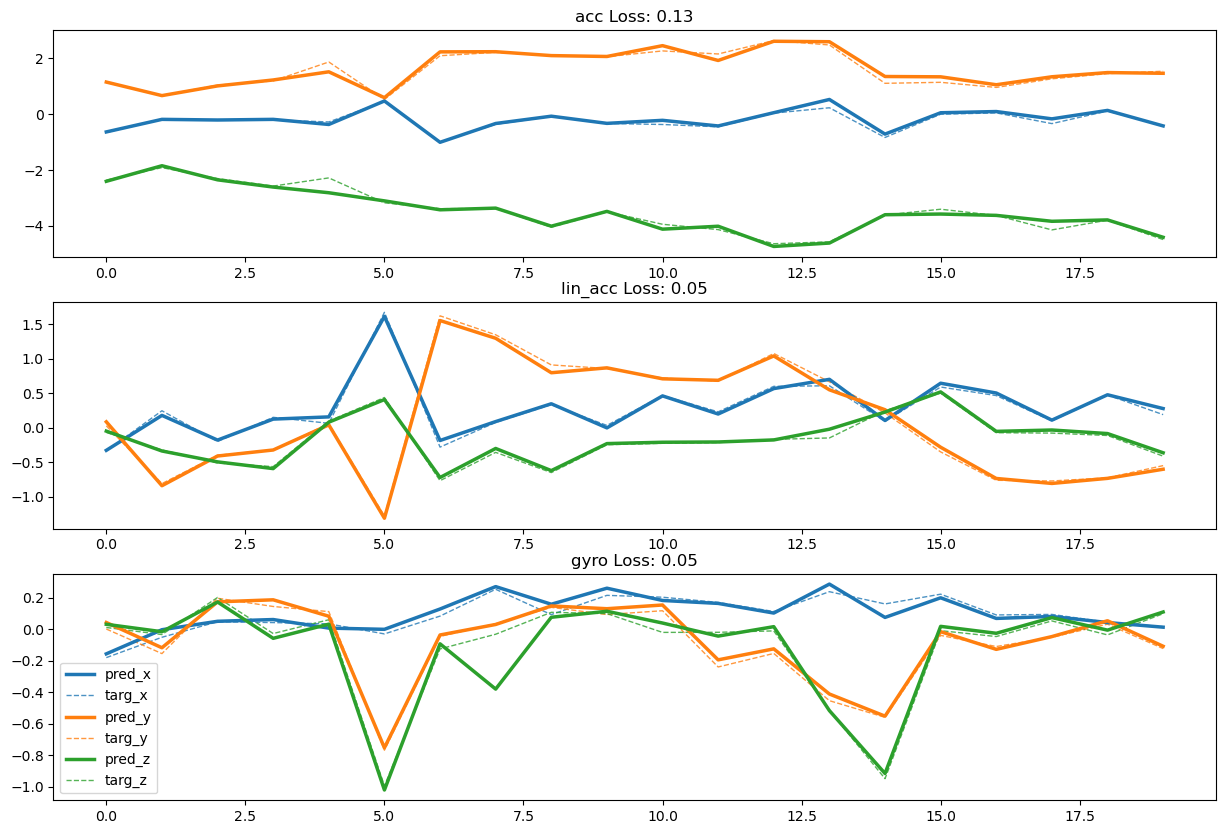

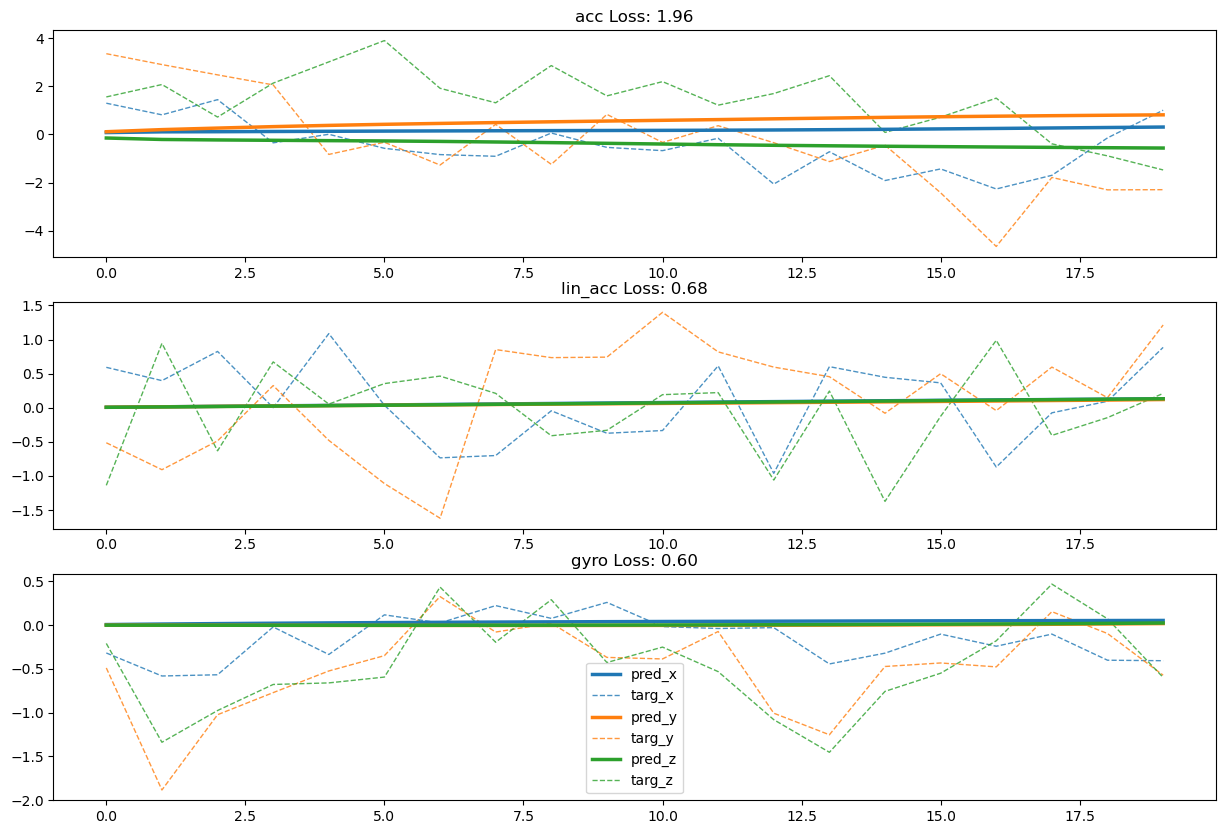

04000: train loss:   0.020, acc loss:  0.013, lin loss:  0.004, gyr loss:  0.003
       valid loss:   4.796, acc loss:  3.791, lin loss:  0.661, gyr loss:  0.344
04100: train loss:   0.019, acc loss:  0.012, lin loss:  0.004, gyr loss:  0.003
       valid loss:   4.751, acc loss:  3.759, lin loss:  0.667, gyr loss:  0.326
04200: train loss:   0.019, acc loss:  0.012, lin loss:  0.004, gyr loss:  0.003
       valid loss:   4.756, acc loss:  3.774, lin loss:  0.655, gyr loss:  0.328
04300: train loss:   0.019, acc loss:  0.013, lin loss:  0.004, gyr loss:  0.003
       valid loss:   4.770, acc loss:  3.781, lin loss:  0.656, gyr loss:  0.334
04400: train loss:   0.019, acc loss:  0.013, lin loss:  0.004, gyr loss:  0.003
       valid loss:   4.912, acc loss:  3.909, lin loss:  0.666, gyr loss:  0.337
04500: train loss:   0.019, acc loss:  0.013, lin loss:  0.004, gyr loss:  0.003
       valid loss:   4.677, acc loss:  3.681, lin loss:  0.659, gyr loss:  0.337
04600: train loss:   0.018, 

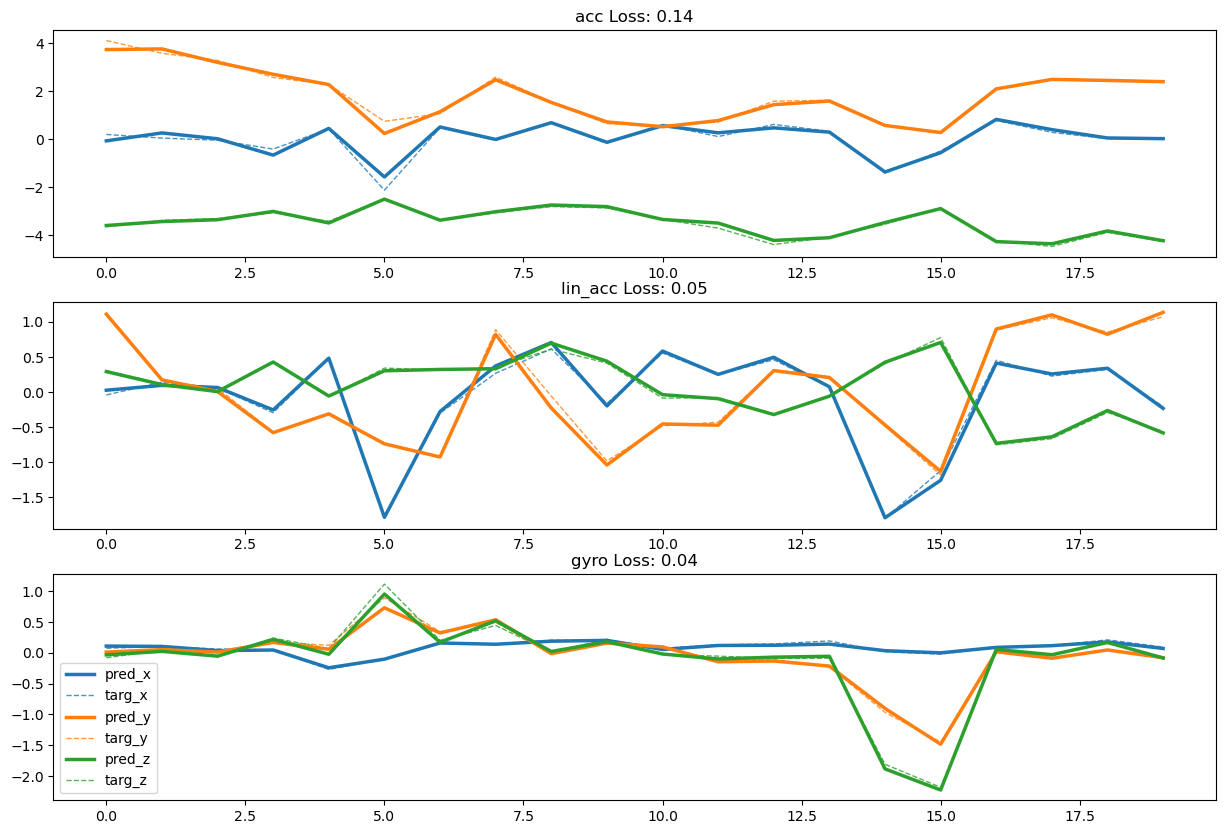

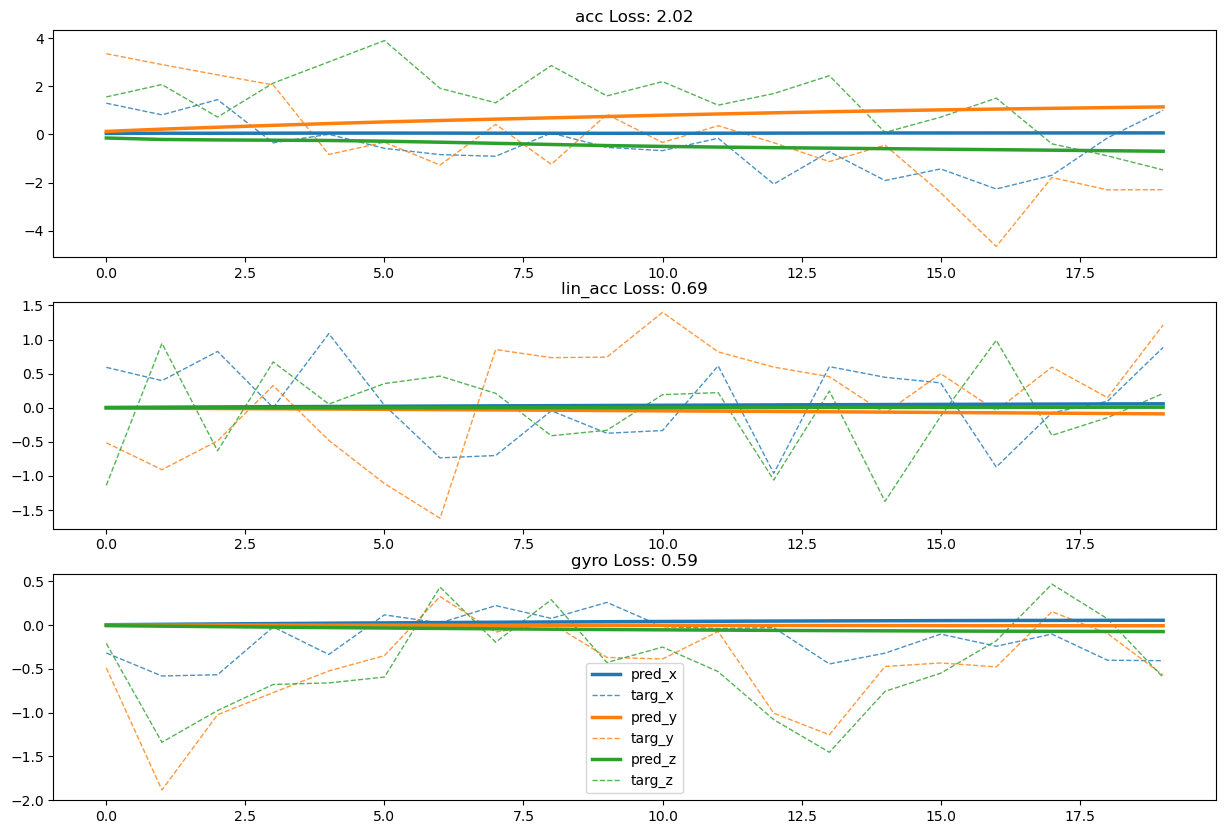

06000: train loss:   0.015, acc loss:  0.010, lin loss:  0.003, gyr loss:  0.002
       valid loss:   4.752, acc loss:  3.755, lin loss:  0.663, gyr loss:  0.334
06100: train loss:   0.014, acc loss:  0.009, lin loss:  0.003, gyr loss:  0.002
       valid loss:   4.647, acc loss:  3.627, lin loss:  0.672, gyr loss:  0.347
06200: train loss:   0.014, acc loss:  0.010, lin loss:  0.003, gyr loss:  0.002
       valid loss:   4.539, acc loss:  3.550, lin loss:  0.661, gyr loss:  0.328
06300: train loss:   0.014, acc loss:  0.009, lin loss:  0.003, gyr loss:  0.002
       valid loss:   4.571, acc loss:  3.586, lin loss:  0.655, gyr loss:  0.329
06400: train loss:   0.013, acc loss:  0.008, lin loss:  0.003, gyr loss:  0.002
       valid loss:   4.703, acc loss:  3.698, lin loss:  0.660, gyr loss:  0.344
06500: train loss:   0.013, acc loss:  0.009, lin loss:  0.003, gyr loss:  0.002
       valid loss:   4.594, acc loss:  3.611, lin loss:  0.655, gyr loss:  0.329
06600: train loss:   0.012, 

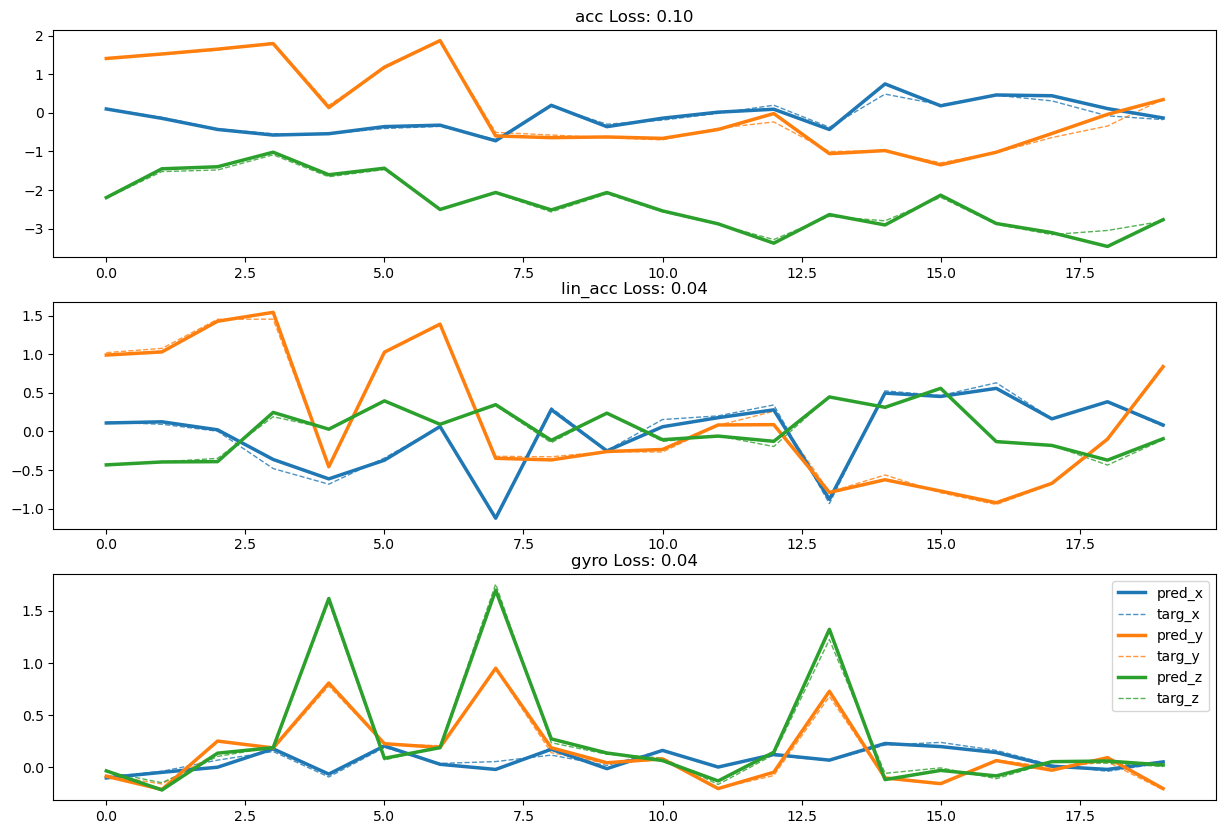

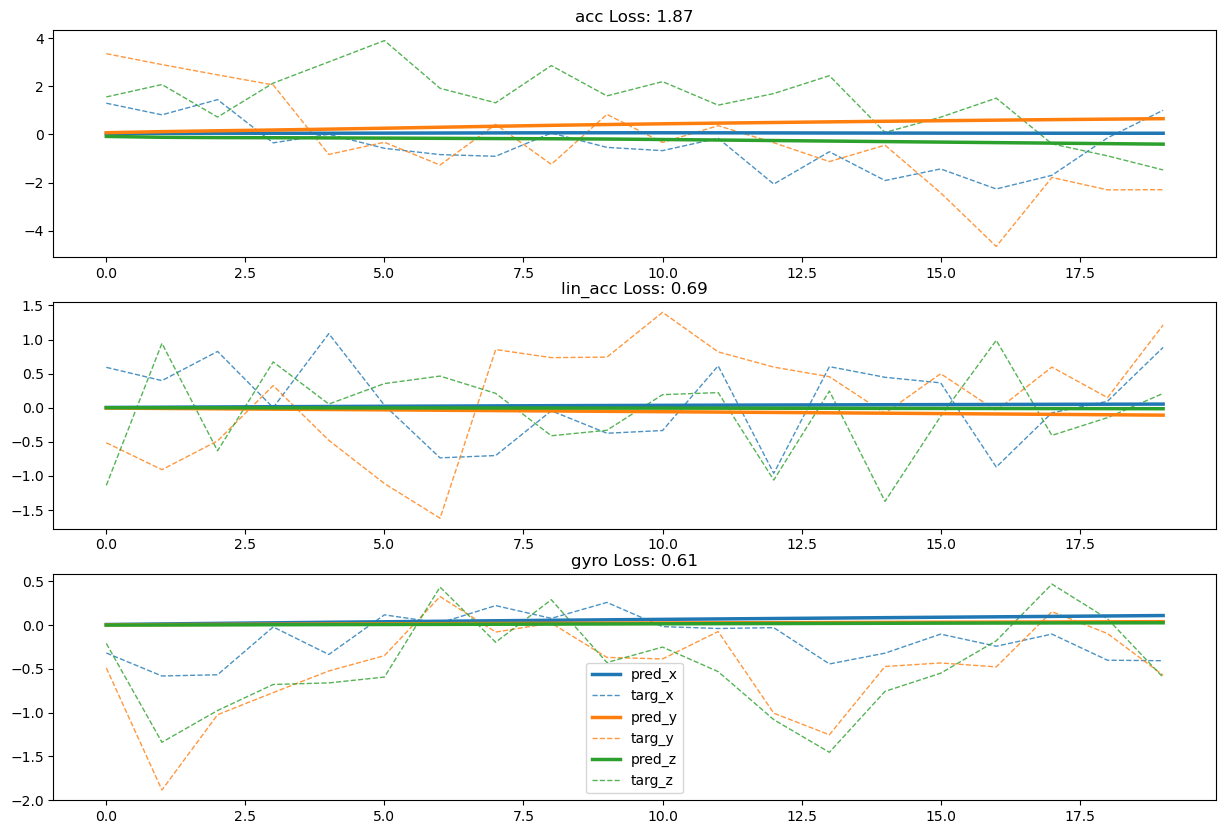

08000: train loss:   0.011, acc loss:  0.007, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.503, acc loss:  3.500, lin loss:  0.660, gyr loss:  0.343
08100: train loss:   0.011, acc loss:  0.007, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.486, acc loss:  3.476, lin loss:  0.668, gyr loss:  0.342
08200: train loss:   0.011, acc loss:  0.007, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.539, acc loss:  3.551, lin loss:  0.663, gyr loss:  0.325
08300: train loss:   0.011, acc loss:  0.008, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.481, acc loss:  3.489, lin loss:  0.662, gyr loss:  0.331
08400: train loss:   0.011, acc loss:  0.007, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.427, acc loss:  3.425, lin loss:  0.671, gyr loss:  0.330
08500: train loss:   0.011, acc loss:  0.007, lin loss:  0.002, gyr loss:  0.002
       valid loss:   4.401, acc loss:  3.405, lin loss:  0.666, gyr loss:  0.331
08600: train loss:   0.011, 

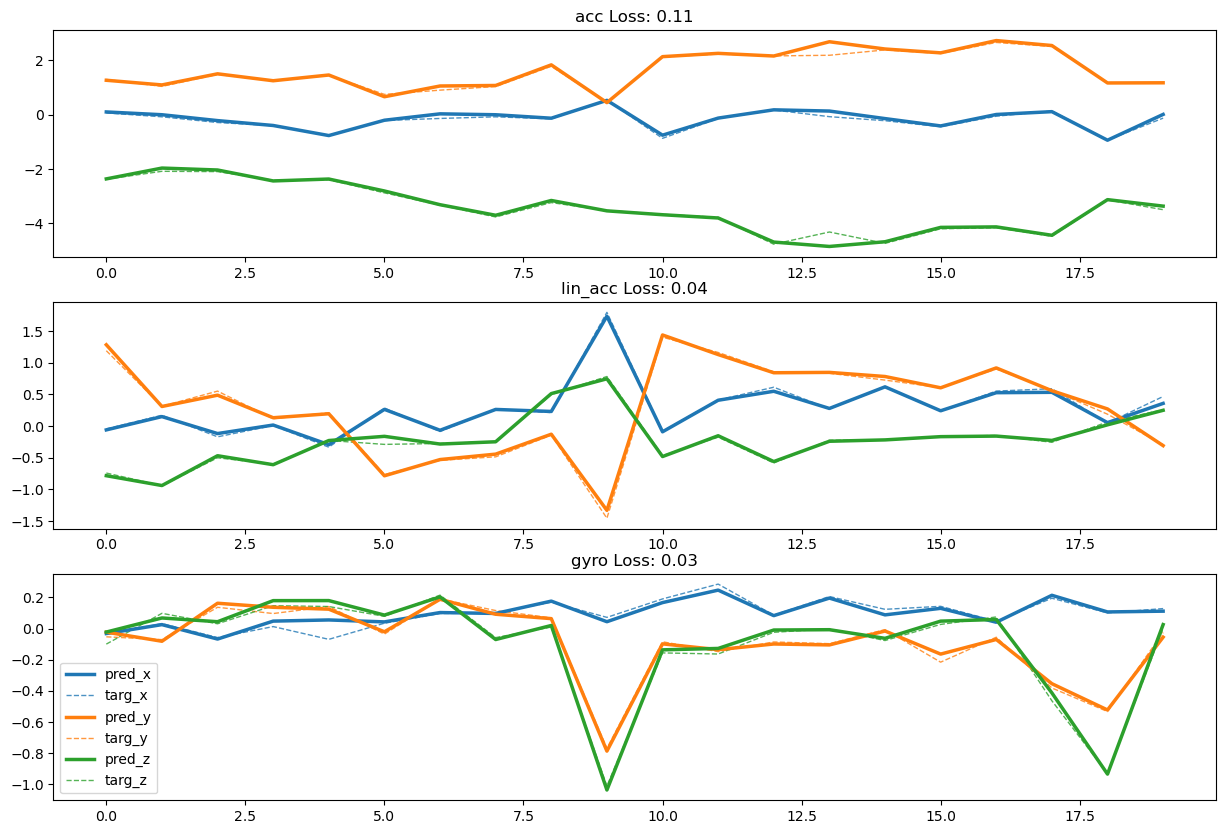

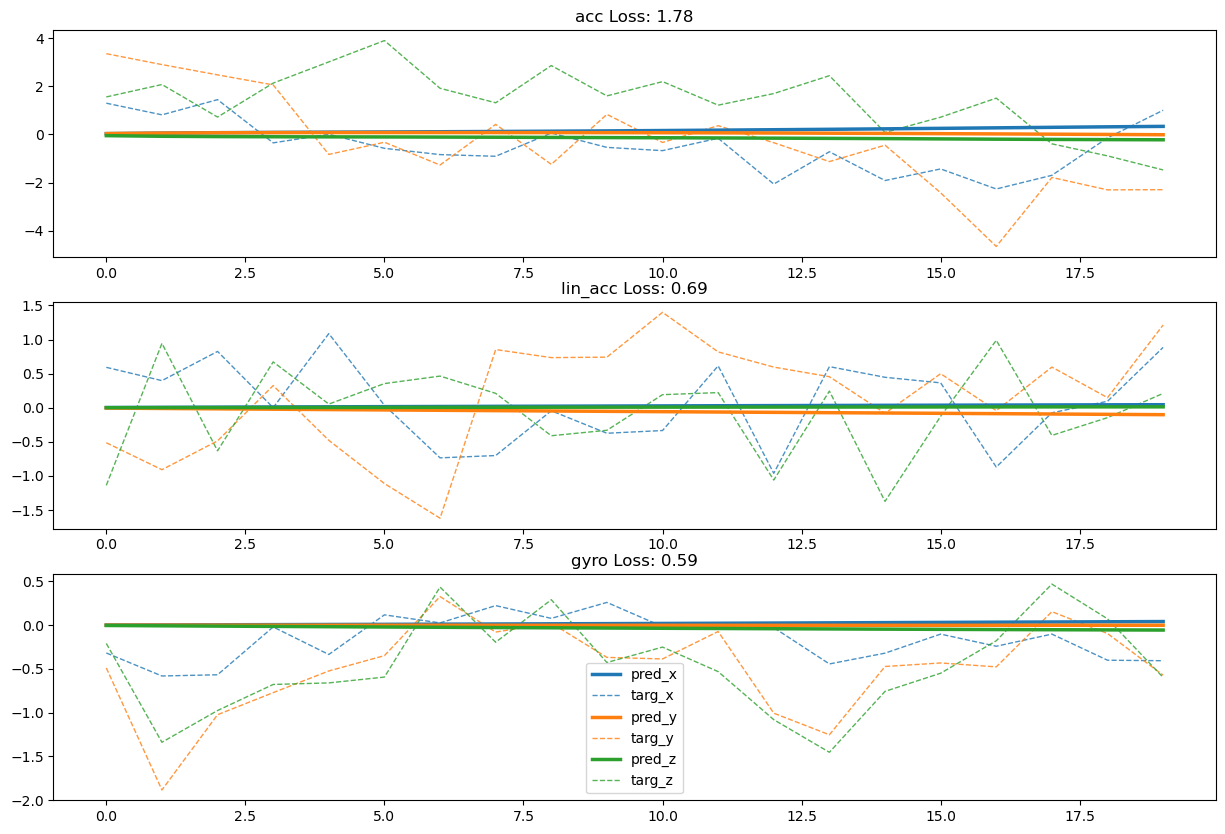

10000: train loss:   0.010, acc loss:  0.007, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.372, acc loss:  3.383, lin loss:  0.656, gyr loss:  0.333
10100: train loss:   0.010, acc loss:  0.006, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.402, acc loss:  3.402, lin loss:  0.662, gyr loss:  0.339
10200: train loss:   0.009, acc loss:  0.006, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.418, acc loss:  3.425, lin loss:  0.658, gyr loss:  0.335
10300: train loss:   0.009, acc loss:  0.006, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.431, acc loss:  3.430, lin loss:  0.661, gyr loss:  0.341
10400: train loss:   0.009, acc loss:  0.006, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.465, acc loss:  3.475, lin loss:  0.652, gyr loss:  0.337
10500: train loss:   0.009, acc loss:  0.006, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.565, acc loss:  3.564, lin loss:  0.658, gyr loss:  0.344
10600: train loss:   0.008, 

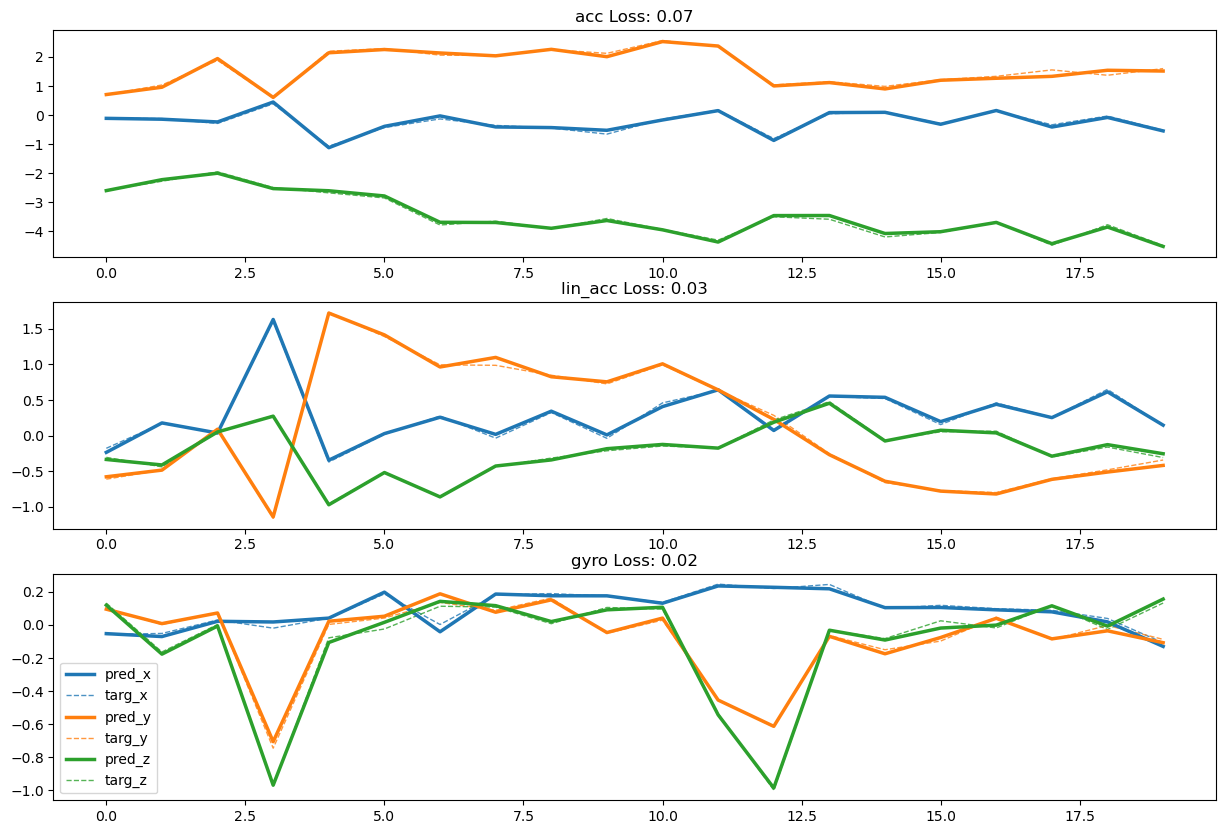

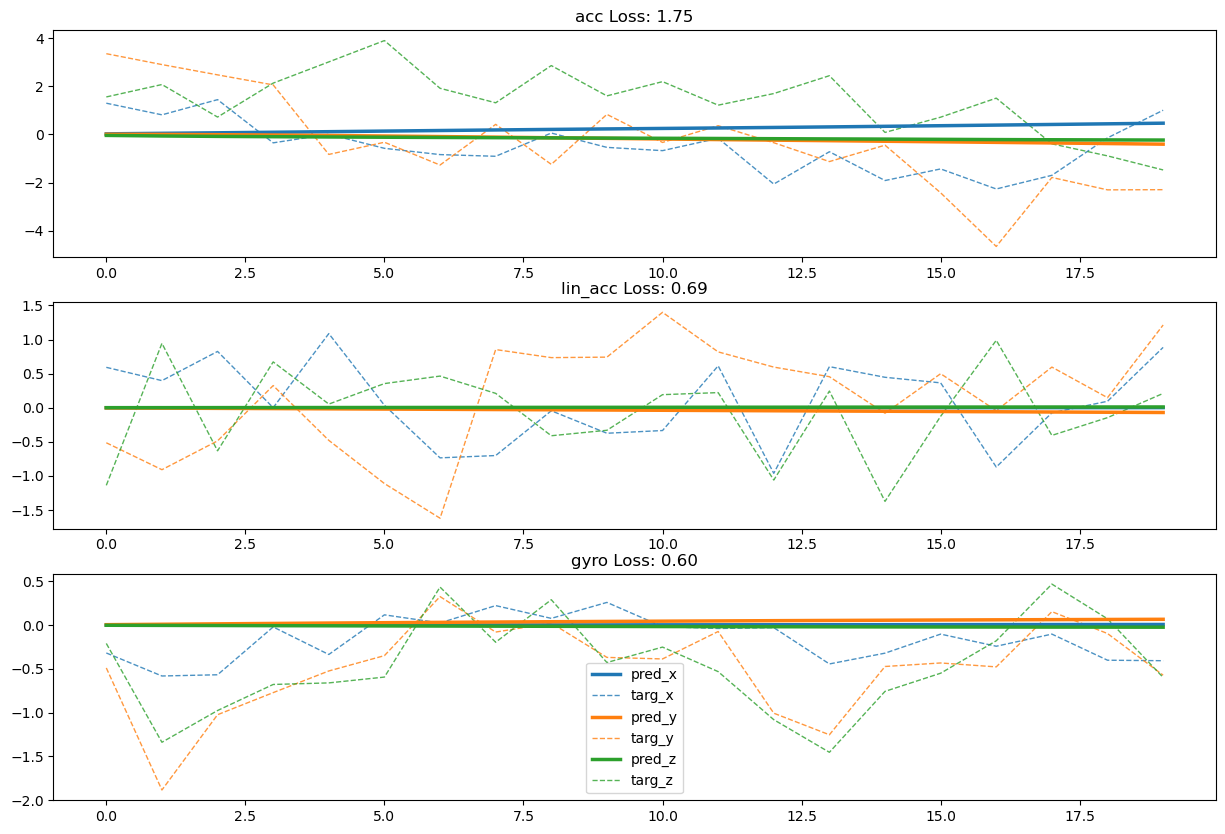

12000: train loss:   0.008, acc loss:  0.005, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.466, acc loss:  3.467, lin loss:  0.656, gyr loss:  0.343
12100: train loss:   0.008, acc loss:  0.005, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.544, acc loss:  3.547, lin loss:  0.651, gyr loss:  0.346
12200: train loss:   0.008, acc loss:  0.005, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.616, acc loss:  3.617, lin loss:  0.652, gyr loss:  0.347
12300: train loss:   0.008, acc loss:  0.005, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.608, acc loss:  3.610, lin loss:  0.658, gyr loss:  0.340
12400: train loss:   0.008, acc loss:  0.006, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.532, acc loss:  3.538, lin loss:  0.657, gyr loss:  0.337
12500: train loss:   0.008, acc loss:  0.005, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.599, acc loss:  3.605, lin loss:  0.658, gyr loss:  0.336
12600: train loss:   0.008, 

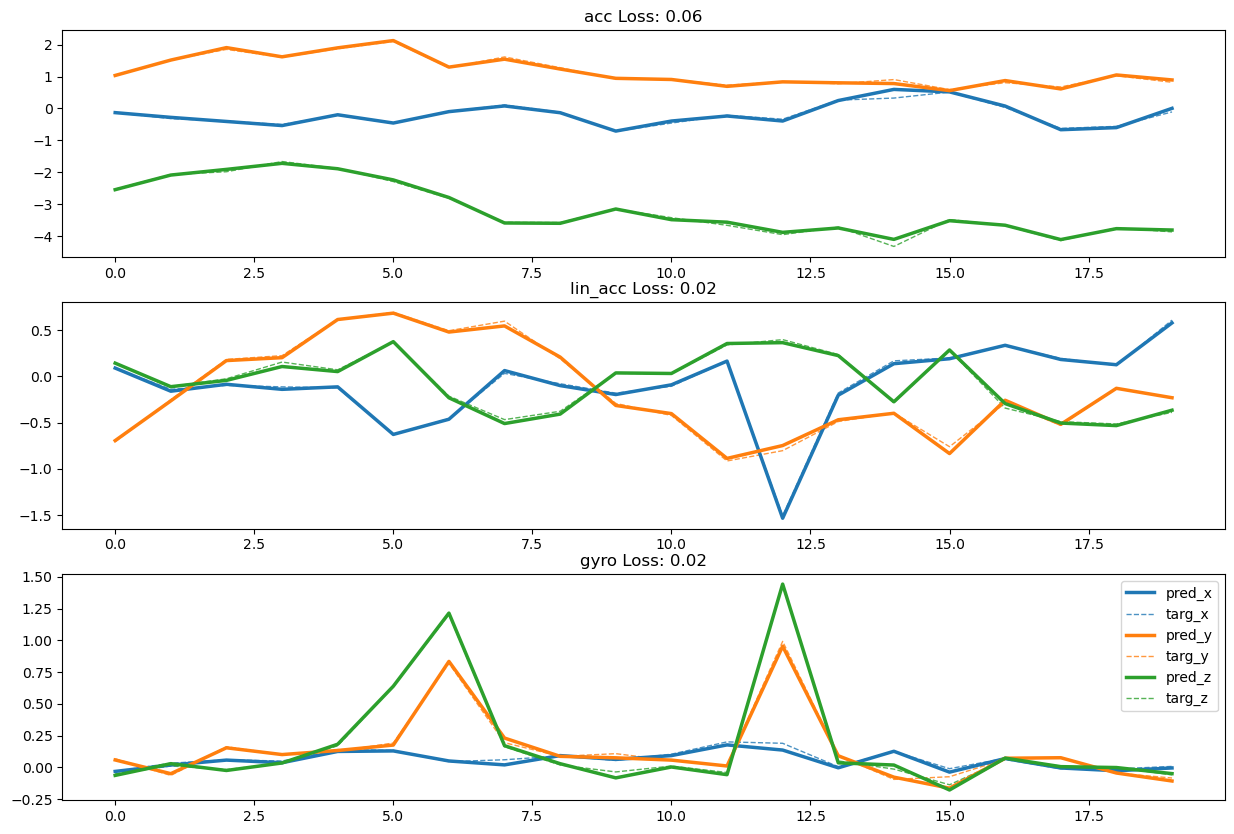

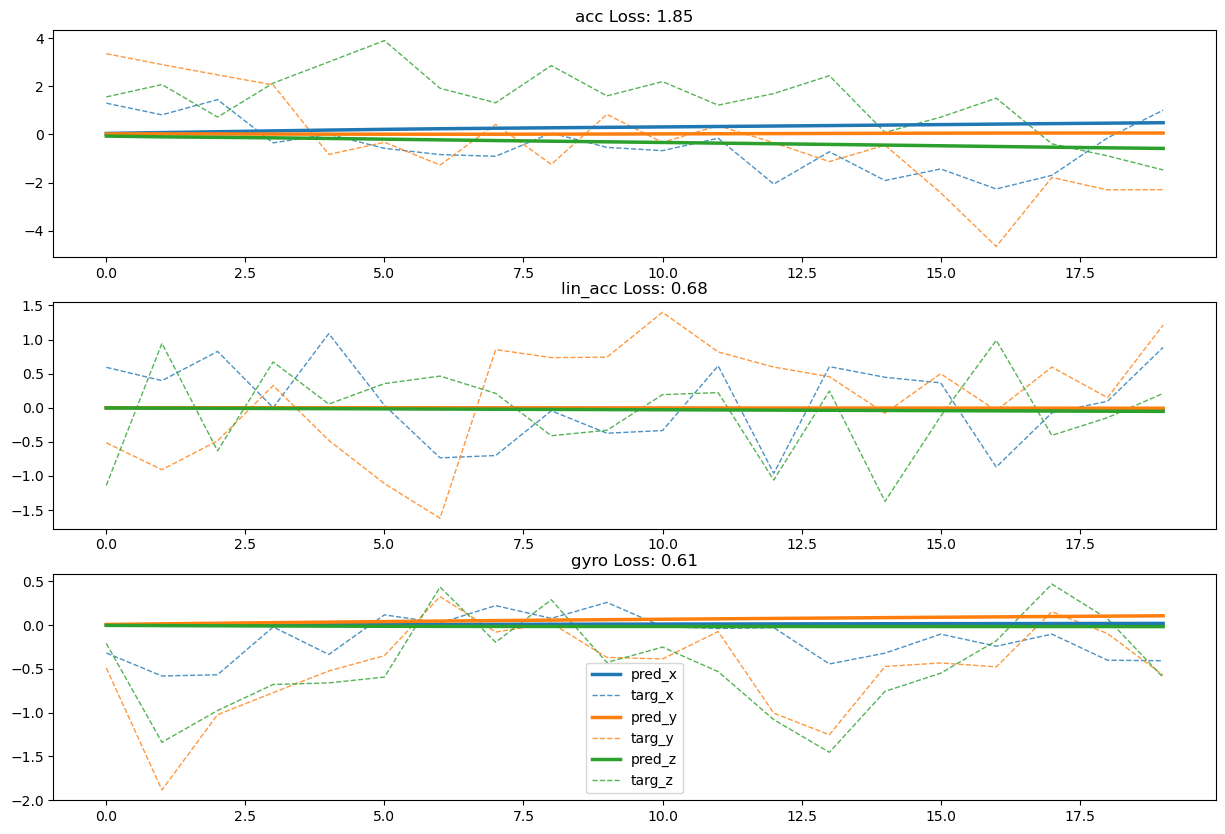

14000: train loss:   0.007, acc loss:  0.005, lin loss:  0.001, gyr loss:  0.001
       valid loss:   4.538, acc loss:  3.536, lin loss:  0.653, gyr loss:  0.349
14100: train loss:   0.007, acc loss:  0.005, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.558, acc loss:  3.567, lin loss:  0.657, gyr loss:  0.334
14200: train loss:   0.007, acc loss:  0.005, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.485, acc loss:  3.499, lin loss:  0.653, gyr loss:  0.333
14300: train loss:   0.008, acc loss:  0.005, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.489, acc loss:  3.498, lin loss:  0.653, gyr loss:  0.338
14400: train loss:   0.007, acc loss:  0.005, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.500, acc loss:  3.510, lin loss:  0.652, gyr loss:  0.338
14500: train loss:   0.007, acc loss:  0.004, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.491, acc loss:  3.496, lin loss:  0.655, gyr loss:  0.340
14600: train loss:   0.007, 

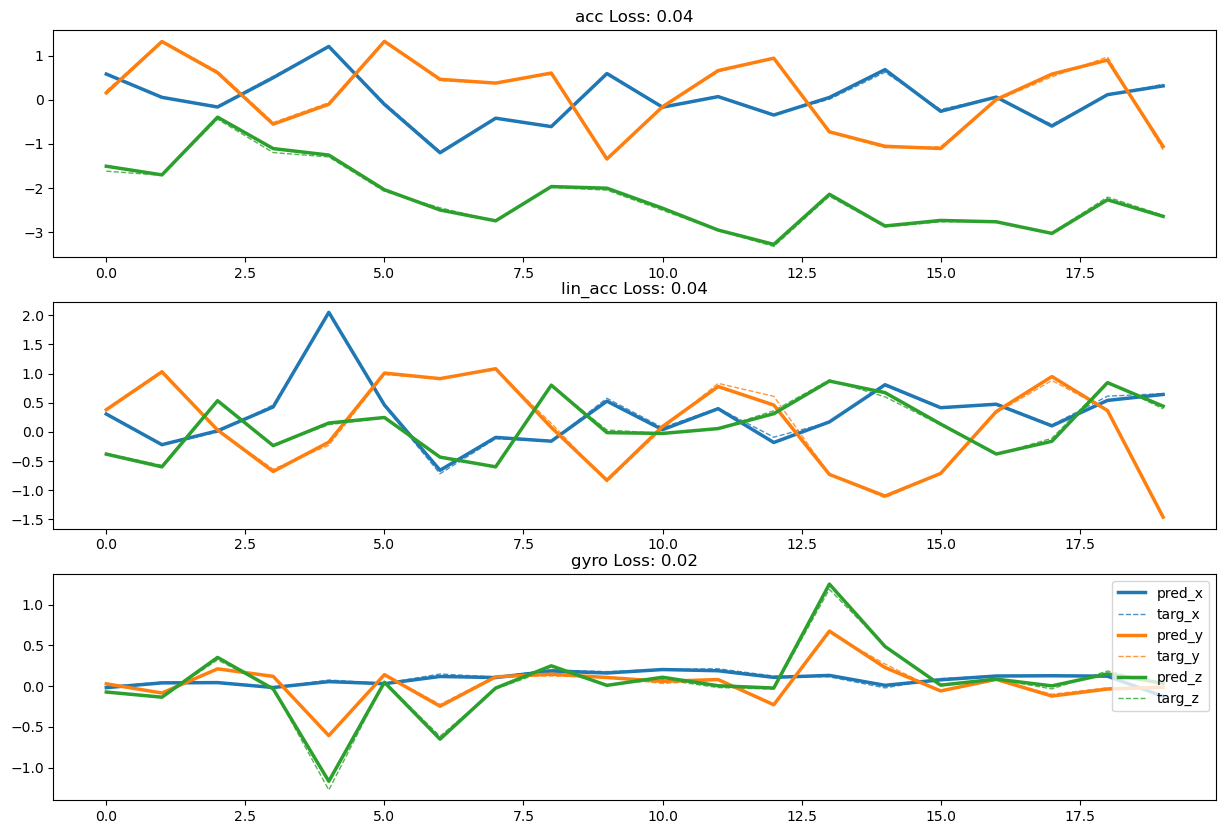

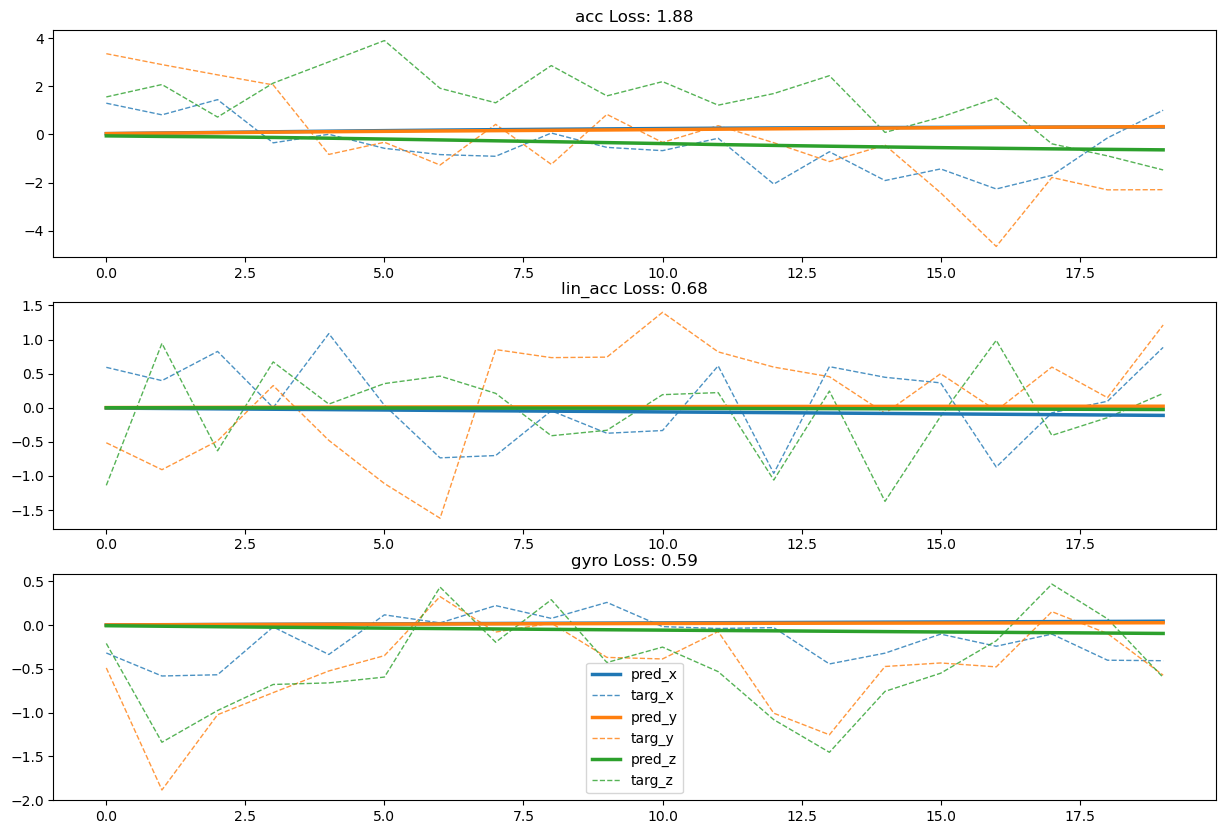

16000: train loss:   0.007, acc loss:  0.004, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.630, acc loss:  3.635, lin loss:  0.660, gyr loss:  0.335
16100: train loss:   0.006, acc loss:  0.004, lin loss:  0.001, gyr loss:  0.001
       valid loss:   4.519, acc loss:  3.516, lin loss:  0.659, gyr loss:  0.343
16200: train loss:   0.006, acc loss:  0.004, lin loss:  0.001, gyr loss:  0.001
       valid loss:   4.567, acc loss:  3.572, lin loss:  0.654, gyr loss:  0.340
16300: train loss:   0.007, acc loss:  0.005, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.476, acc loss:  3.496, lin loss:  0.651, gyr loss:  0.329
16400: train loss:   0.007, acc loss:  0.005, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.466, acc loss:  3.478, lin loss:  0.653, gyr loss:  0.335
16500: train loss:   0.007, acc loss:  0.004, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.476, acc loss:  3.481, lin loss:  0.658, gyr loss:  0.337
16600: train loss:   0.007, 

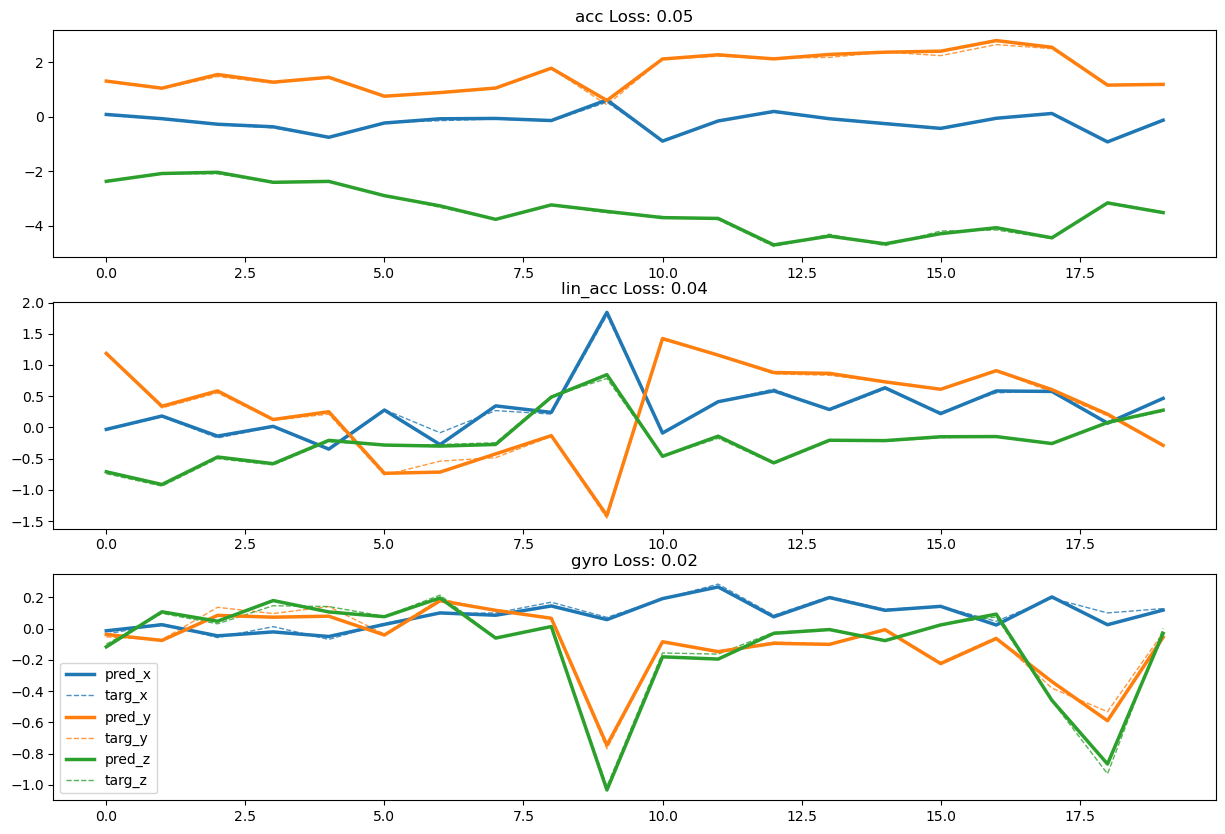

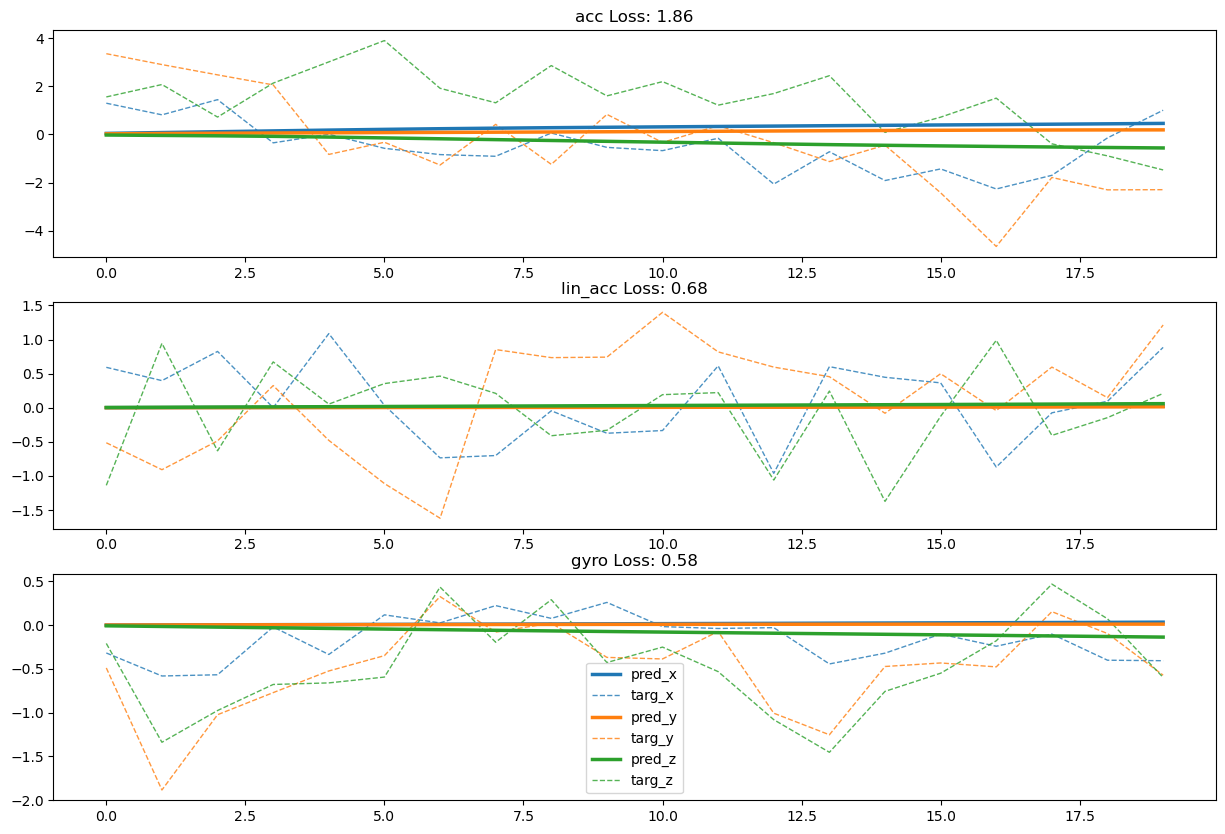

18000: train loss:   0.007, acc loss:  0.005, lin loss:  0.001, gyr loss:  0.001
       valid loss:   4.527, acc loss:  3.546, lin loss:  0.652, gyr loss:  0.329
18100: train loss:   0.006, acc loss:  0.004, lin loss:  0.001, gyr loss:  0.001
       valid loss:   4.565, acc loss:  3.573, lin loss:  0.651, gyr loss:  0.341
18200: train loss:   0.006, acc loss:  0.004, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.556, acc loss:  3.561, lin loss:  0.655, gyr loss:  0.339
18300: train loss:   0.006, acc loss:  0.004, lin loss:  0.001, gyr loss:  0.001
       valid loss:   4.554, acc loss:  3.560, lin loss:  0.653, gyr loss:  0.341
18400: train loss:   0.006, acc loss:  0.004, lin loss:  0.002, gyr loss:  0.001
       valid loss:   4.508, acc loss:  3.519, lin loss:  0.656, gyr loss:  0.333
18500: train loss:   0.006, acc loss:  0.004, lin loss:  0.001, gyr loss:  0.001
       valid loss:   4.449, acc loss:  3.452, lin loss:  0.658, gyr loss:  0.338
18600: train loss:   0.006, 

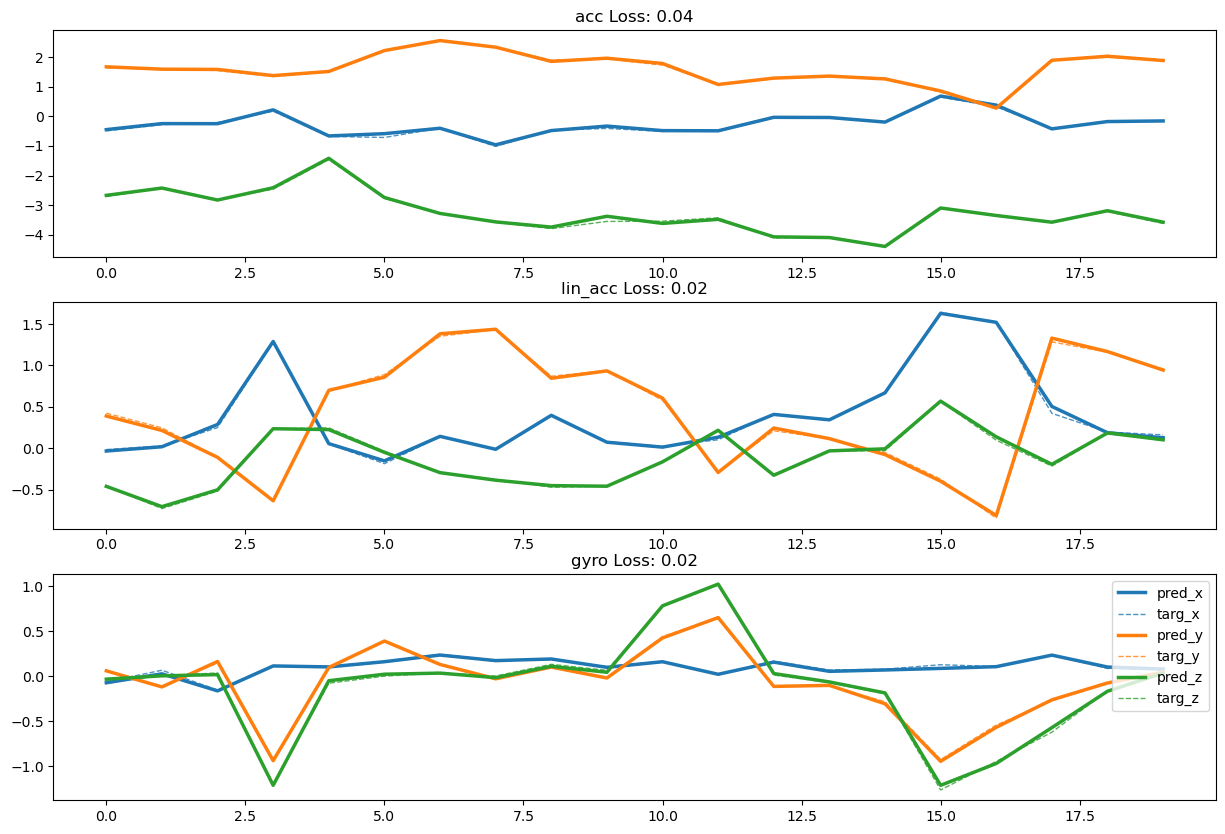

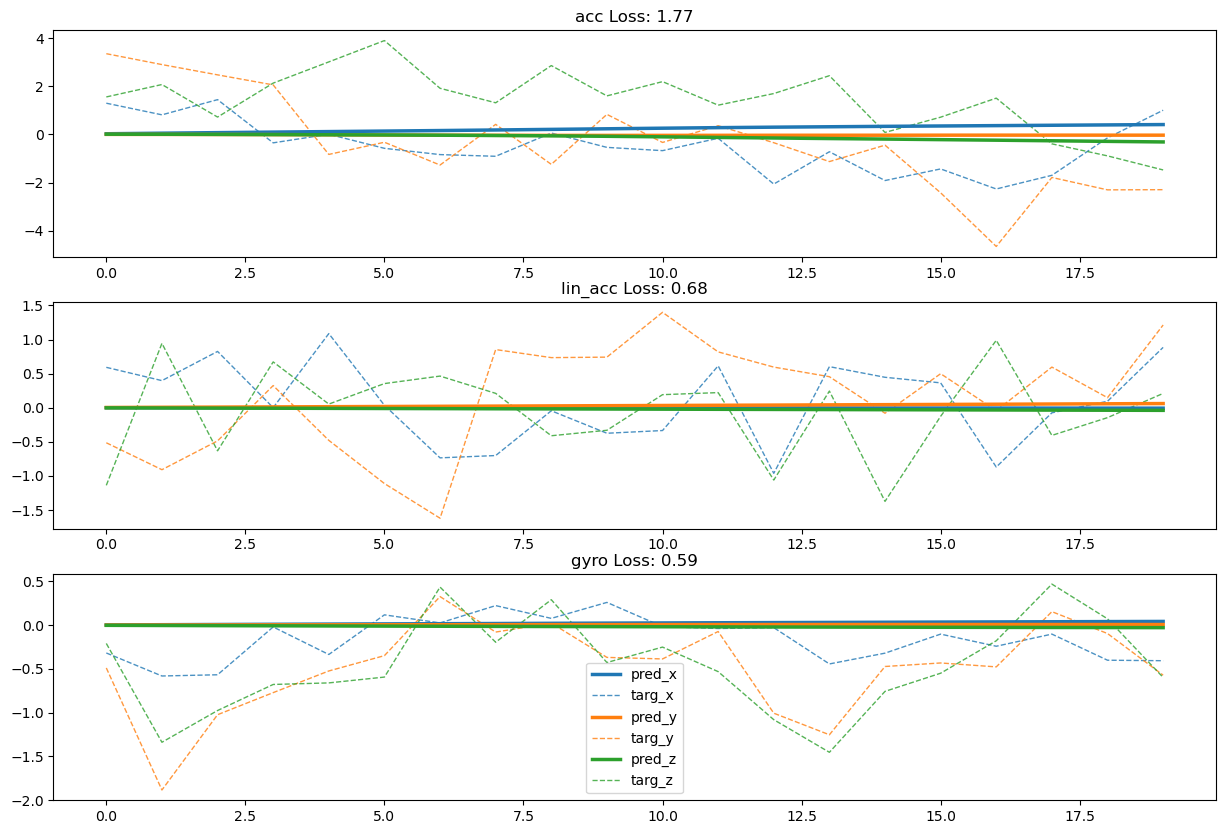

20000: train loss:   0.006, acc loss:  0.003, lin loss:  0.001, gyr loss:  0.001
       valid loss:   4.355, acc loss:  3.367, lin loss:  0.652, gyr loss:  0.336


In [23]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH+1):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    draw = ((epoch) % 2000 == 0)
    
    train_loss, train_acc_loss, train_lin_loss, train_gyr_loss = train(train_loader, draw, epoch / EPOCH)
    
    if epoch % 100 == 0:
        valid_loss, valid_acc_loss, valid_lin_loss, valid_gyr_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>7.3f}, acc loss: {train_acc_loss:>6.3f}, lin loss: {train_lin_loss:>6.3f}, gyr loss: {train_gyr_loss:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>7.3f}, acc loss: {valid_acc_loss:>6.3f}, lin loss: {valid_lin_loss:>6.3f}, gyr loss: {valid_gyr_loss:>6.3f}')

(330, 3) (330, 3, 3) (330,)
       acc loss name|   diff x   diff y   diff z      avg
   front_pocket loss:     0.43     2.15     8.22     3.60
         pocket loss:     0.42     2.14     8.10     3.56
          swing loss:     0.41     2.15     8.41     3.66
        average loss:     0.42     2.15     8.24     3.61
   lin_acc loss name|   diff x   diff y   diff z      avg
   front_pocket loss:     0.33     0.59     0.23     0.38
         pocket loss:     0.33     0.59     0.23     0.38
          swing loss:     0.33     0.59     0.23     0.38
        average loss:     0.33     0.59     0.23     0.38
      gyro loss name|   diff x   diff y   diff z      avg
   front_pocket loss:     0.00     0.00     0.00     0.00
         pocket loss:     0.00     0.00     0.00     0.00
          swing loss:     0.00     0.00     0.00     0.00
        average loss:     0.00     0.00     0.00     0.00


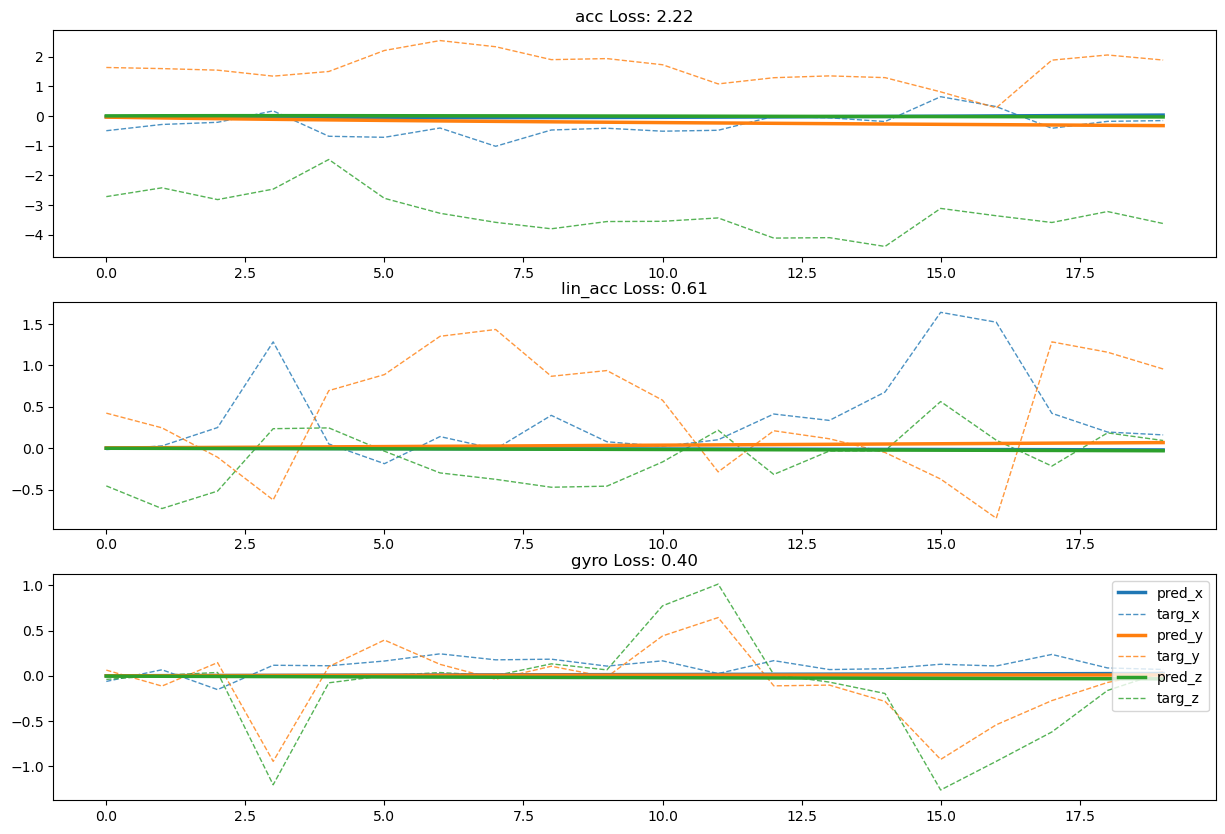

In [30]:
show_result(model, train_loader)

(39, 3) (39, 3, 3) (39,)
       acc loss name|   diff x   diff y   diff z      avg
   front_pocket loss:     1.16     4.77     3.80     3.24
         pocket loss:     1.20     4.90     3.92     3.34
          swing loss:     1.37     5.13     4.05     3.52
        average loss:     1.24     4.93     3.92     3.37
   lin_acc loss name|   diff x   diff y   diff z      avg
   front_pocket loss:     0.32     0.77     0.87     0.65
         pocket loss:     0.32     0.78     0.86     0.65
          swing loss:     0.32     0.77     0.87     0.65
        average loss:     0.32     0.77     0.87     0.65
      gyro loss name|   diff x   diff y   diff z      avg
   front_pocket loss:     0.00     0.00     0.00     0.00
         pocket loss:     0.00     0.00     0.00     0.00
          swing loss:     0.00     0.00     0.00     0.00
        average loss:     0.00     0.00     0.00     0.00


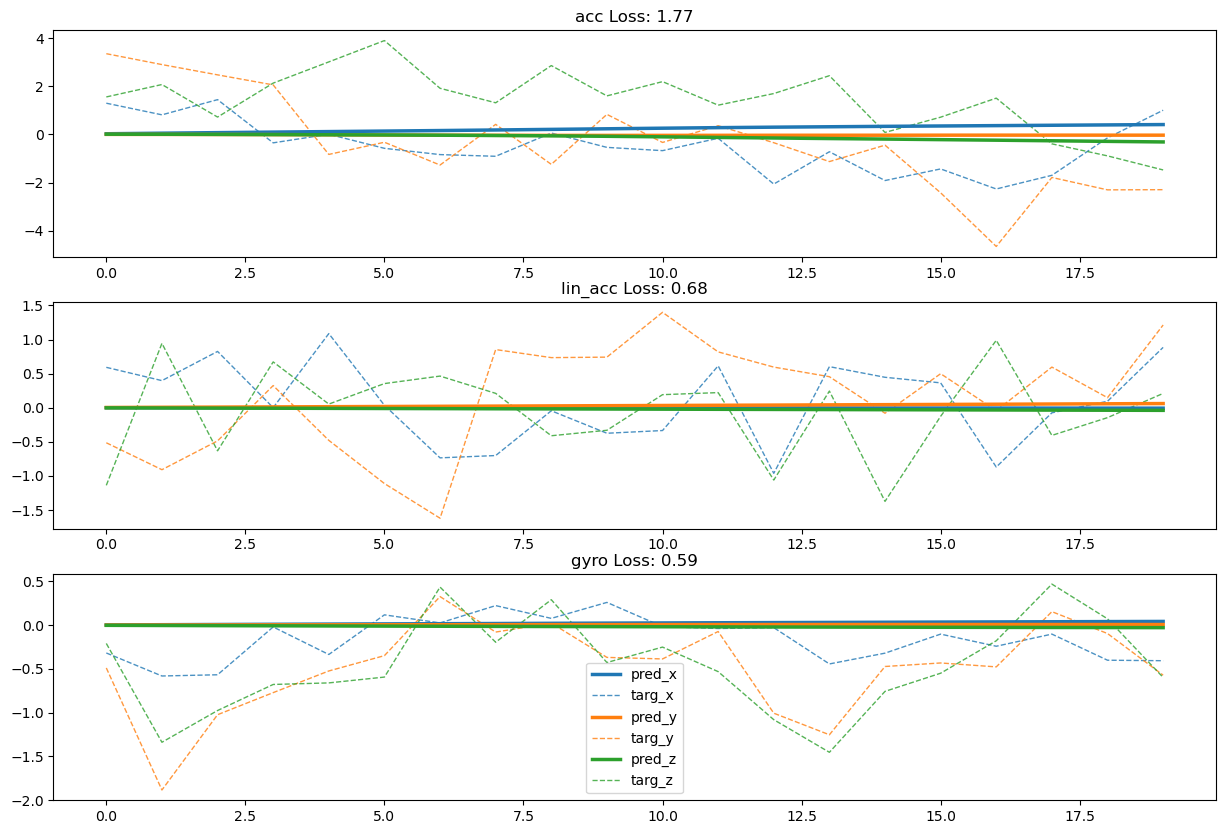

In [31]:
show_result(model, valid_loader)

In [ ]:
torch.save(model, f'{path}/{gt}_{num_of_axis}_{rotation}_rework.pt')
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()

In [ ]:
num_of_axis, rotation, gt = 3, True, 'target'

posture_data = get_data(validation_traj, num_of_axis, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'])
# prep_valid_traj['horizontal']   = split_traj(posture_data['horizontal'])
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'])
prep_valid_traj['swing']        = split_traj(posture_data['swing'])
prep_valid_traj['target']       = split_traj(posture_data['target'])

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
acc_para = list(model.acc_layer.parameters()) + list(model.acc_encoder.parameters()) + list(model.acc_decoder.parameters()) + list(model.acc_nn.parameters())
lin_para = list(model.lin_acc_layer.parameters()) + list(model.lin_acc_encoder.parameters()) + list(model.lin_acc_decoder.parameters()) + list(model.lin_acc_nn.parameters())
gyr_para = list(model.gyro_layer.parameters()) + list(model.gyro_encoder.parameters()) + list(model.gyro_decoder.parameters()) + list(model.gyro_nn.parameters())

optimizer_acc = torch.optim.Adam(acc_para, lr=0.0001)
optimizer_lin = torch.optim.Adam(lin_para, lr=0.0001)
optimizer_gyr = torch.optim.Adam(gyr_para, lr=0.0001)

In [ ]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH+1):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    draw = ((epoch) % 2000 == 0)
    
    train_loss, train_acc_loss, train_lin_loss, train_gyr_loss = train(train_loader, draw, epoch / EPOCH)
    
    if epoch % 100 == 0:
        valid_loss, valid_acc_loss, valid_lin_loss, valid_gyr_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>7.3f}, acc loss: {train_acc_loss:>6.3f}, lin loss: {train_lin_loss:>6.3f}, gyr loss: {train_gyr_loss:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>7.3f}, acc loss: {valid_acc_loss:>6.3f}, lin loss: {valid_lin_loss:>6.3f}, gyr loss: {valid_gyr_loss:>6.3f}')

In [ ]:
show_result(model, train_loader)

In [ ]:
show_result(model, valid_loader)

In [ ]:
torch.save(model, f'{path}/{gt}_{num_of_axis}_{rotation}_rework.pt')
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()

In [ ]:
num_of_axis, rotation, gt = 3, False, 'horizontal'

posture_data = get_data(validation_traj, num_of_axis, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'])
prep_valid_traj['horizontal']   = split_traj(posture_data['horizontal'])
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'])
prep_valid_traj['swing']        = split_traj(posture_data['swing'])
prep_valid_traj['target']       = split_traj(posture_data['target'])

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
imu_layer_params = list(model.imu_layer.parameters())
encoder_params = list(model.encoder.parameters())
nn_params = list(model.nn.parameters())
initial_params = imu_layer_params + encoder_params + nn_params
optimizer = torch.optim.Adam(initial_params, lr=0.0001)

In [ ]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH+1):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    if epoch == 1000: optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    draw = ((epoch) % 20000 == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw, epoch / EPOCH)
    
    if (epoch) % 100 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>7.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>7.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

In [ ]:
show_result(model, train_loader)

In [ ]:
show_result(model, valid_loader)

In [ ]:
torch.save(model, f'{path}/{gt}_{num_of_axis}_{rotation}_rework.pt')
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()